In [ ]:
# Export Smoke Test: validate exports for meta-model consumption
from pathlib import Path
import numpy as np
import json
import sys

# Resolve project root
BASE_PATH = Path.cwd()
for p in [BASE_PATH, *BASE_PATH.parents]:
    if (p / '.git').exists():
        BASE_PATH = p
        break

ADVANCED_SPATIAL_ROOT = BASE_PATH / 'models' / 'output' / 'advanced_spatial'
META_DIR = ADVANCED_SPATIAL_ROOT / 'meta_models'
META_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Checking exports in: {META_DIR}")

report = {
    'root': str(META_DIR),
    'exports_checked': 0,
    'valid_exports': 0,
    'errors': [],
    'common_shape': None
}

try:
    if not META_DIR.exists():
        raise FileNotFoundError(f"Meta models directory not found: {META_DIR}")

    subdirs = [d for d in META_DIR.iterdir() if d.is_dir()]
    if not subdirs:
        raise RuntimeError("No export subdirectories found. Ensure export step ran successfully.")

    shapes = []
    for sub in sorted(subdirs):
        pred_f = sub / 'predictions.npy'
        targ_f = sub / 'targets.npy'
        meta_f = sub / 'metadata.json'

        report['exports_checked'] += 1

        if not pred_f.exists() or not targ_f.exists():
            report['errors'].append(f"Missing predictions/targets in {sub}")
            continue

        try:
            pred = np.load(pred_f)
            targ = np.load(targ_f)
        except Exception as e:
            report['errors'].append(f"Failed to load arrays in {sub}: {e}")
            continue

        # Shape checks
        if pred.ndim != 4 or targ.ndim != 4:
            report['errors'].append(f"Invalid dims in {sub}: pred {pred.shape}, targ {targ.shape} (expected 4D)")
            continue
        if pred.shape != targ.shape:
            report['errors'].append(f"Shape mismatch in {sub}: pred {pred.shape} vs targ {targ.shape}")
            continue

        # Basic content checks
        if not np.isfinite(pred).all():
            report['errors'].append(f"Non-finite values in predictions: {sub}")
            continue
        if not np.isfinite(targ).all():
            report['errors'].append(f"Non-finite values in targets: {sub}")
            continue
        if pred.size == 0:
            report['errors'].append(f"Empty predictions array: {sub}")
            continue

        shapes.append(pred.shape)
        report['valid_exports'] += 1

        # Metadata presence (optional but recommended)
        if not meta_f.exists():
            report['errors'].append(f"Missing metadata.json in {sub}")

    if not shapes:
        raise RuntimeError("No valid exports found. See errors for details.")

    # Determine common shape and store it
    N = min(s[0] for s in shapes)
    H = min(s[1] for s in shapes)
    Y = min(s[2] for s in shapes)
    X = min(s[3] for s in shapes)
    report['common_shape'] = [N, H, Y, X]

    print(f"✅ Export smoke test passed: {report['valid_exports']} valid of {report['exports_checked']} checked")
    print(f"   Common shape: {tuple(report['common_shape'])}")

except Exception as e:
    report['errors'].append(str(e))
    print(f"❌ Export smoke test failed: {e}")

# Persist report for CI/traceability
try:
    (META_DIR / 'export_smoke_test.json').write_text(json.dumps(report, indent=2))
    print(f"📝 Wrote {META_DIR / 'export_smoke_test.json'}")
except Exception as e:
    print(f"⚠️ Could not write smoke test report: {e}")



<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/advanced_spatial_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Proposed Improvements for Spatial Precipitation Models

### 1. Hyperparameter Optimization

| Parameter     | Original Value | Improved Value | Justification                 |
| ------------- | -------------- | -------------- | ----------------------------- |
| Batch Size    | 4              | **16**         | Greater gradient stability    |
| Learning Rate | 1e-3           | **5e-4**       | Smoother convergence          |
| Epochs        | 50             | **100**        | More time with early stopping |
| Patience      | 6              | **10**         | Prevent premature stopping    |
| Dropout       | 0              | **0.2**        | Regularization                |
| L2 Reg        | 0              | **1e-5**       | Prevent overfitting           |

### 2. Improved Architectures

#### Attention ConvLSTM (ConvLSTM\_Att)

```python
- 3 ConvLSTM layers (64→32→16 filters)
- CBAM (Channel + Spatial Attention)
- BatchNorm + Dropout in each layer
- Multi-scale head (1×1, 3×3, 5×5)
```

#### Residual ConvGRU (ConvGRU\_Res)

```python
- Skip connections from input
- Enhanced BatchNorm
- 2 ConvGRU blocks (64→32 filters)
- Final residual connection
```

#### Hybrid Transformer (Hybrid\_Trans)

```python
- CNN temporal encoder
- Multi-head attention (4 heads)
- LSTM for temporal aggregation
- Spatial decoder
```

### 3. Advanced Techniques

#### Learning Rate Scheduling

* **Warmup**: Initial 5 epochs
* **Cosine Decay**: Smooth reduction after warmup
* **ReduceLROnPlateau**: Additional reduction if stalled

#### Data Augmentation

* Gaussian noise (σ=0.005)
* Maintains spatial and temporal coherence

#### Regularization

* Spatial dropout (0.2)
* L2 regularization on all weights
* Batch Normalization

## 📈 Expected Improvements

### By Horizon:

* **H=1**: RMSE < 40 (\~8% improvement)
* **H=2**: RMSE < 30, R² > 0.5 (significant improvement)
* **H=3**: RMSE < 65, R² > 0.65 (\~10% improvement)

### By Model:

1. **ConvLSTM\_Att**: Improved capture of relevant spatial patterns
2. **ConvGRU\_Res**: Greater stability and reduced temporal degradation
3. **Hybrid\_Trans**: Enhanced modeling of long-range dependencies

## 🚀 Next Steps

### Short-term:

1. Train models with improved configurations
2. Validate metric improvements
3. Regional error analysis

### Medium-term:

1. **Ensemble Methods**: Combine best models
2. **Multi-Task Learning**: Predict multiple variables simultaneously
3. **Physics-Informed Loss**: Incorporate physical constraints

### Long-term:

1. **3D Models**: ConvLSTM3D to capture elevation
2. **Graph Neural Networks**: Address irregular spatial relations
3. **Uncertainty Quantification**: Confidence intervals

## 🔍 Baseline Comparison

The script automatically generates comparisons with original models, displaying:

* % improvement in RMSE
* Evolution of R² per horizon
* Summary table of best models


In [2]:
# ───────────────────────── IMPORTS Y CONFIGURACIÓN ─────────────────────────
from __future__ import annotations
from pathlib import Path
import sys, os, gc, warnings
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, ConvLSTM2D, LSTM,SimpleRNN, LSTM, GRU, Flatten, Dense, Reshape, RepeatVector,
    Lambda, Permute, Layer, TimeDistributed, BatchNormalization, Dropout, Add,
    Add, Multiply, Concatenate, GlobalAveragePooling2D, Activation,
    LayerNormalization, MultiHeadAttention, MaxPooling2D, Embedding, Conv3D
)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    CSVLogger, Callback, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import imageio.v2 as imageio
from IPython.display import clear_output, display, Image
import json
from datetime import datetime
from typing import List, Dict, Any, Tuple, Optional



## ╭─────────────────────────── Paths ──────────────────────────╮
# ▶️ Path configuration
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # Install necessary dependencies
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy geopandas
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break

print('BASE_PATH =', BASE_PATH)

import cartopy.crs as ccrs

# Paths
DATA_DIR = BASE_PATH / 'data' / 'output'
OUT_ROOT = BASE_PATH / 'models' / 'output' / 'advanced_spatial'
MODEL_OUTPUT_DIR = OUT_ROOT.parent
MODEL_ROOT = BASE_PATH / 'models'
OUT_ROOT.mkdir(exist_ok=True)
BASE_MODEL_DIR = OUT_ROOT / 'base_models'
BASE_MODEL_DIR.mkdir(exist_ok=True)
MODEL_DIR = OUT_ROOT
SHAPE_DIR = BASE_PATH / 'data' / 'input' / 'shapes'
MODEL_INPUT_DIR = BASE_PATH/'data'/'input'/'shapes'
MODEL_INPUT_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_DIR = OUT_ROOT/'images'
IMAGE_DIR.mkdir(exist_ok=True)
GIF_DIR = OUT_ROOT / "gifs"
GIF_DIR.mkdir(exist_ok=True)
# Dataset paths
FULL_NC = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation.nc'
FULL_NC_CLEAN = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
DEPT_GDF = gpd.read_file(SHAPE_DIR/'MGN_Departamento.shp')

print(f"📁 BASE_PATH: {BASE_PATH}")
print(f"📊 Dataset: {FULL_NC_CLEAN.name if FULL_NC_CLEAN.exists() else FULL_NC.name}")

# ───────────────────────── IMPROVED CONFIGURATION ─────────────────────────
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')  # Higher resolution context
plt.rcParams['figure.figsize'] = (14, 10)  # Larger default figure size
plt.rcParams['figure.dpi'] = 120  # Higher DPI for display
plt.rcParams['savefig.dpi'] = 700  # Higher DPI for saved figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['lines.linewidth'] = 2

# GPU config
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

print("✅ Imports completados")

# ╰────────────────────────────────────────────────────────────╯

Mounted at /content/drive
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.8 MB/s eta 0:00:00
BASE_PATH = /content/drive/MyDrive/ml_precipitation_prediction
📁 BASE_PATH: /content/drive/MyDrive/ml_precipitation_prediction
📊 Dataset: complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Mounted at /content/drive
✅ Imports completados


In [3]:
# ╭──────────────────── Global hyperparameters ─────────────╮
INPUT_WINDOW   = 60
HORIZON        = 3  # Forecast horizon in months
TARGET_VAR     = 'total_precipitation'
EPOCHS         = 120
BATCH_SIZE     = 4           # small size → less RAM GPU
PATIENCE       = 100
LR             = 1e-3
L2_REG         = 1e-5 # L2 regularization
DROPOUT        = 0.2 # Dropout
# ╰────────────────────────────────────────────────────────────╯


In [4]:
# ╭──────────────────────── Datasets ────────────────────────────╮
LAG_VARS = ['total_precipitation_lag1',
            'total_precipitation_lag2',
            'total_precipitation_lag12']

if FULL_NC_CLEAN.exists():
    print(f"🟢 Clean dataset found → {FULL_NC_CLEAN.name}")
    ds = xr.open_dataset(FULL_NC_CLEAN)

else:
    # ============================================================
    print(f"🟠 Warning: clean dataset not found.\n")
    ds = xr.open_dataset(FULL_NC)
    print("\n📊  Global summary of NaNs")
    print("─"*55)
    for var in LAG_VARS:
        arr    = ds[var].values
        total  = arr.size
        n_nans = int(np.isnan(arr).sum())
        print(f"{var:<28}: {n_nans:>8,} / {total:,}  ({n_nans/total:6.2%})")

    # ============================================================
    print("\n🕒  Dates with NaNs by variable")
    print("─"*55)
    for var in LAG_VARS:
        arr         = ds[var].values
        nan_per_ts  = np.isnan(arr).reshape(len(ds.time), -1).sum(axis=1)
        if nan_per_ts.sum() == 0:
            print(f"{var}: no NaNs ✔️")
            continue

        df_nan = (pd
                  .DataFrame({"time": pd.to_datetime(ds.time.values),
                              "na_cells": nan_per_ts})
                  .query("na_cells > 0"))

        # first 3 and last 3 dates with NaNs
        head = df_nan.head(3).to_string(index=False)
        tail = df_nan.tail(3).to_string(index=False)
        last = df_nan["time"].iloc[-1].strftime("%Y-%m")

        print(f"\n{var}")
        print(head)
        if len(df_nan) > 6:
            print("   …")
        print(tail)
        print(f"   ⇢  last date with NaNs: {last}")

    # ============================================================
    # First date in which the THREE variables are 100 % clean
    # ------------------------------------------------------------
    def last_nan_index(var: str) -> int:
        """Index of the last timestamp that contains at least one NaN in `var`."""
        nan_per_ts = np.isnan(ds[var].values).reshape(len(ds.time), -1).sum(axis=1)
        idxs       = np.where(nan_per_ts > 0)[0]
        return idxs[-1] if len(idxs) else -1

    last_nan_any = max(last_nan_index(v) for v in LAG_VARS)
    first_clean  = pd.to_datetime(ds.time.values[last_nan_any + 1])

    print("\nFirst date 100 % free of NaNs in ALL lags:",
          first_clean.strftime("%Y-%m"))

    ds_clean = ds.sel(time=~(ds['time.year'] == 1981))   # discard ALL 1981

    print("🔎  Timestamps before:", len(ds.time))
    print("🔎  Timestamps after:", len(ds_clean.time))

    # 3) Save new NetCDF file
    ds_clean.to_netcdf(FULL_NC_CLEAN, mode='w')
    print(f"💾  Dataset sin 1981 guardado en {FULL_NC_CLEAN}")

    # 4) (-- optional --)  check that there are no NaNs in the lags
    LAG_VARS = ['total_precipitation_lag1',
                'total_precipitation_lag2',
                'total_precipitation_lag12']

    print("\n📊  Remaining NaNs after removing 1981")
    print("─"*50)
    for var in LAG_VARS:
        n_nan = int(np.isnan(ds_clean[var].values).sum())
        print(f"{var:<28}: {n_nan:,} NaNs")

    ds = ds_clean
# ╰────────────────────────────────────────────────────────────╯

🟢 Clean dataset found → complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc


In [5]:
# Time windows for training and validation (in months)
VALIDATION_WINDOW = 24
TRAINING_WINDOW = 60

# Simplified fold structure with reference dates
FOLDS = {
    'F1': {
        'active': True,
        'ref_date': '2024-12'  # Reference date for the fold
    }
}


In [6]:
# ╭──────────────────────── Shapes ────────────────────────────╮
lat, lon    = len(ds.latitude), len(ds.longitude)
cells       = lat * lon
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────────── Metrics ────────────────────────╮

def evaluate(y_true: np.ndarray, y_pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────── Base ConvLSTM model ────────────────╮

@tf.keras.utils.register_keras_serializable()
def tile_step_emb(batch_ref, step_emb_tab):
    # Static shape (TensorShape / TensorSpec)
    if isinstance(batch_ref, (tf.TensorShape, tf.TensorSpec)):
        return tf.TensorShape([batch_ref[0],
                               step_emb_tab.shape[0],
                               step_emb_tab.shape[1]])
    # Execution
    b   = tf.shape(batch_ref)[0]
    emb = tf.expand_dims(step_emb_tab, 0)
    return tf.tile(emb, [b, 1, 1])
# ╰────────────────────────────────────────────────────────────╯
custom = {'tile_step_emb': tile_step_emb}

def _build_convlstm_ed(
        *,
        input_window: int,
        output_horizon: int,
        spatial_height: int,
        spatial_width: int,
        n_features: int,
        n_filters: int = 64,
        n_heads: int = 4,
        use_attention: bool = True,
        use_positional_emb: bool = True,
        lr: float = 1e-3
    ) -> Model:
    """
    Encoder-Decoder ConvLSTM + GRU.
    If `use_positional_emb` = True, add an output step embedding
    that prevents the model from generating the same prediction for all horizons.
    """

    # ──────────────── Encoder ────────────────
    enc_inputs = Input(
        shape=(input_window, spatial_height, spatial_width, n_features),
        name="enc_input"
    )

    x = ConvLSTM2D(n_filters, (3, 3), padding='same',
                   return_sequences=True,  name="enc_lstm_1")(enc_inputs)
    x = ConvLSTM2D(n_filters // 2, (3, 3), padding='same',
                   return_sequences=False, name="enc_lstm_2")(x)

    # ── Flatten grid and repeat context T_out times ──
    flat = Flatten(name="flatten_spatial")(x)                 # (B, H·W·C)
    ctx  = RepeatVector(output_horizon, name="context")(flat) # (B, T_out, H·W·C)

    # ── Positional embedding ──
    if use_positional_emb:
        # Create step IDs as constant input
        step_ids_input = Input(shape=(output_horizon,), dtype=tf.int32, name="step_ids")

        # Embedding layer
        step_emb_layer = Embedding(output_horizon, n_filters, name="step_embedding")
        step_emb = step_emb_layer(step_ids_input)  # (B, T_out, D)

        # Concatenate with context
        dec_in = Concatenate(name="dec_concat")([ctx, step_emb])

        # Update model inputs
        model_inputs = [enc_inputs, step_ids_input]
    else:
        dec_in = ctx
        model_inputs = enc_inputs

    # ─────────────── Temporal decoder ───────────────
    dec = GRU(2 * n_filters, return_sequences=True, name="dec_gru")(dec_in) # (B, T_out, 2·F)

    # ─────── Attention (optional) ───────
    if use_attention:
        attn = MultiHeadAttention(num_heads=n_heads,
                                  key_dim=n_filters,
                                  dropout=0.1,
                                  name="mha")(dec, dec)
        dec  = Add(name="mha_residual")([dec, attn])
        dec  = LayerNormalization(name="mha_norm")(dec)

    # ───────────── Projection to grid ─────────────
    proj = TimeDistributed(
        Dense(spatial_height * spatial_width, activation='linear'),
        name="dense_proj"
    )(dec)                                                    # (B, T_out, H·W)

    out = Reshape(
        (output_horizon, spatial_height, spatial_width, 1),
        name="reshape_out"
    )(proj)

    name = ("ConvLSTM_ED_Attn_PE" if use_attention else "ConvLSTM_ED_PE") \
           if use_positional_emb else \
           ("ConvLSTM_ED_Attn"     if use_attention else "ConvLSTM_ED")

    model = Model(model_inputs, out, name=name)
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

# Factories ---------------------------------------------------

def factory_no_attn(**kw):
    return _build_convlstm_ed(use_attention=False, **kw)

def factory_attn(**kw):
    return _build_convlstm_ed(use_attention=True, **kw)
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────── Experiments & Folds ─────────────────╮
# ▸ We only show the first three levels; add the others equally
BASE_FEATURES = [
    'year','month','month_sin','month_cos','doy_sin','doy_cos',
    'max_daily_precipitation','min_daily_precipitation','daily_precipitation_std',
    'elevation','slope','aspect'
]
ELEV_CLUSTER = ['elev_high','elev_med','elev_low']
KCE_FEATURES = BASE_FEATURES + ELEV_CLUSTER
PAFC_FEATURES= KCE_FEATURES + ['total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag12']

EXPERIMENTS: Dict[str, Dict[str, Any]] = {
    'ConvLSTM-ED': {
        'active': True,
        'feature_list': BASE_FEATURES,
        'builder': factory_attn, #factory_no_attn,
        'n_filters': 64,
        'n_heads'  : 4
    },
    'ConvLSTM-ED-KCE': {
        'active': True,
        'feature_list': KCE_FEATURES,
        'builder': factory_attn,
        'n_filters': 64,
        'n_heads'  : 4,
    },
    'ConvLSTM-ED-KCE-PAFC': {
        'active': True,
        'feature_list': PAFC_FEATURES,
        'builder': factory_attn,
        'n_filters': 96,
        'n_heads'  : 6,
    },
}
# ╰────────────────────────────────────────────────────────────╯

# ╭──────────────────── Sliding windows ───────────────────╮

def make_windows(mask:np.ndarray, allow_past_context:bool)->tuple[np.ndarray,np.ndarray]:
    """Generates windows **discarding** those containing NaNs.

    Modified to handle sliding windows properly for training and validation.
    """
    seq_X, seq_y = [], []

    # Get indices of True values in mask
    mask_indices = np.where(mask)[0]

    if len(mask_indices) == 0:
        print("Warning: Empty mask provided")
        return np.array(seq_X), np.array(seq_y)

    # For training windows (allow_past_context=False)
    if not allow_past_context:
        # For training, we create sliding windows within the available data
        # We need at least INPUT_WINDOW consecutive points to start
        if len(mask_indices) < INPUT_WINDOW:
            print(f"Warning: Not enough data points in mask for training ({len(mask_indices)} < {INPUT_WINDOW})")
            return np.array(seq_X), np.array(seq_y)

        # Check if indices are consecutive
        consecutive_groups = []
        current_group = [mask_indices[0]]

        for i in range(1, len(mask_indices)):
            if mask_indices[i] == mask_indices[i-1] + 1:
                current_group.append(mask_indices[i])
            else:
                if len(current_group) >= INPUT_WINDOW:
                    consecutive_groups.append(current_group)
                current_group = [mask_indices[i]]

        # Don't forget the last group
        if len(current_group) >= INPUT_WINDOW:
            consecutive_groups.append(current_group)

        # Create windows from each consecutive group
        for group in consecutive_groups:
            # We can create windows up to len(group) - INPUT_WINDOW + 1
            for i in range(len(group) - INPUT_WINDOW + 1):
                # Get input window indices
                start_idx = group[i]
                end_w_idx = start_idx + INPUT_WINDOW - 1

                # Extract input data
                Xw = Xarr[start_idx:end_w_idx+1]

                # For output, we'll use up to HORIZON points after the input window
                # but only if they're within our mask
                y_indices = []
                for h in range(HORIZON):
                    y_idx = end_w_idx + 1 + h
                    if y_idx < len(yarr):  # More flexible for validation
                        y_indices.append(y_idx)
                    else:
                        break

                # Only create a window if we have at least one output point
                if len(y_indices) > 0:
                    yw = yarr[y_indices]

                    # Check for NaNs
                    if not (np.isnan(Xw).any() or np.isnan(yw).any()):
                        # Pad y if necessary
                        if len(y_indices) < HORIZON:
                            y_padded = np.zeros((HORIZON,) + yarr.shape[1:], dtype=yarr.dtype)
                            y_padded[:len(y_indices)] = yw
                            yw = y_padded

                        seq_X.append(Xw)
                        seq_y.append(yw)

    # For validation windows (allow_past_context=True)
    else:
        # For validation, we can use past context - we don't need INPUT_WINDOW consecutive points in the mask
        # Instead, we can use the entire dataset to create input windows that end before validation targets

        if len(mask_indices) == 0:
            print("Warning: Empty validation mask")
            return np.array(seq_X), np.array(seq_y)

        # For each point in the validation mask, try to create a window
        for val_idx in mask_indices:
            # Check if we can create a full INPUT_WINDOW before this validation point
            if val_idx >= INPUT_WINDOW:
                # Create input window ending at (val_idx - 1)
                start_idx = val_idx - INPUT_WINDOW
                end_w_idx = val_idx - 1

                # Extract input data from the full dataset (not just the mask)
                Xw = Xarr[start_idx:end_w_idx+1]

                # For output, use points starting from val_idx
                y_indices = []
                for h in range(HORIZON):
                    y_idx = val_idx + h
                    if y_idx < len(yarr):
                        y_indices.append(y_idx)
                    else:
                        break

                # Create window if we have at least one output point
                if len(y_indices) > 0:
                    yw = yarr[y_indices]

                    # Check for NaNs
                    if not (np.isnan(Xw).any() or np.isnan(yw).any()):
                        # Pad y if necessary
                        if len(y_indices) < HORIZON:
                            y_padded = np.zeros((HORIZON,) + yarr.shape[1:], dtype=yarr.dtype)
                            y_padded[:len(y_indices)] = yw
                            yw = y_padded

                        seq_X.append(Xw)
                        seq_y.append(yw)

    print(f"Created {len(seq_X)} windows")
    return np.array(seq_X), np.array(seq_y)
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────── Main training loop ────────╮
RESULTS: List[Dict[str, Any]] = []

# 🔸 NEW helper ------------------------------------------------

def _impute_nans(a:np.ndarray, per_feature_mean:np.ndarray|None=None, is_target:bool=False)->np.ndarray:
    """Imputes remaining NaNs (extra safety)."""
    if not np.isnan(a).any():
        return a
    if is_target:
        a[np.isnan(a)] = 0.0  # 🔸 NEW – 0 for y
        return a
    if per_feature_mean is None:
        raise ValueError('per_feature_mean required for imputing X')
    flat = a.reshape(-1, a.shape[-1])
    nan_idx = np.isnan(flat)
    for f in range(a.shape[-1]):
        flat[nan_idx[:,f], f] = per_feature_mean[f]  # 🔸 NEW
    return flat.reshape(a.shape)
# ╰────────────────────────────────────────────────────────────╯

# ╭──────────────────── Run all experiments ──────────────────────╮
def run_all_experiments():
    times = pd.to_datetime(ds.time.values)
    total = sum(e['active'] for e in EXPERIMENTS.values()) * sum(f['active'] for f in FOLDS.values())
    cnt   = 0

    for exp_name, exp_cfg in EXPERIMENTS.items():
        if not exp_cfg['active']:
            continue
        vars_     = exp_cfg['feature_list']
        builder   = exp_cfg['builder']      # specific factory
        n_filters = exp_cfg.get('n_filters',64)
        n_heads   = exp_cfg.get('n_heads',4)

        # ─ Pre‑load features for experiment ─────────────────────
        global Xarr, yarr
        Xarr = ds[vars_].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
        yarr = ds[TARGET_VAR].values.astype(np.float32)
        feats = Xarr.shape[-1]

        for fold_name, fold_cfg in FOLDS.items():
            if not fold_cfg['active']:
                continue
            cnt += 1

            # Calculate all dates from the reference date
            ref_date = pd.to_datetime(fold_cfg['ref_date'])

            # Test period starts at reference date and extends for HORIZON months
            test_start = ref_date
            # Use date_range to ensure we get exactly HORIZON months
            test_end = pd.date_range(start=test_start, periods=HORIZON, freq='MS')[-1]

            # Validation period is VALIDATION_WINDOW months before test period
            val_end = test_start - pd.DateOffset(days=1)  # Day before test starts
            # Use date_range to ensure we get exactly VALIDATION_WINDOW months
            val_start = pd.date_range(end=val_end, periods=VALIDATION_WINDOW, freq='MS')[0]

            # Training period is TRAINING_WINDOW months before validation period
            train_end = val_start - pd.DateOffset(days=1)  # Day before validation starts
            # Use date_range to ensure we get exactly TRAINING_WINDOW months
            train_start = pd.date_range(end=train_end, periods=TRAINING_WINDOW, freq='MS')[0]

            # Format dates for display
            train_start_str = train_start.strftime('%Y-%m')
            train_end_str = train_end.strftime('%Y-%m')
            val_start_str = val_start.strftime('%Y-%m')
            val_end_str = val_end.strftime('%Y-%m')
            test_start_str = test_start.strftime('%Y-%m')
            test_end_str = test_end.strftime('%Y-%m')

            print(f"\n▶️  [{cnt}/{total}] {exp_name} – {fold_name}")
            print(f"    Reference date: {fold_cfg['ref_date']}")
            print(f"    Training: {train_start_str} to {train_end_str}")
            print(f"    Validation: {val_start_str} to {val_end_str}")
            print(f"    Test: {test_start_str} to {test_end_str}")

            # Verify that we have data for these date ranges
            mask_tr = (times >= train_start) & (times <= train_end)
            mask_val = (times >= val_start) & (times <= val_end)

            # Check if we have enough data in the dataset
            print(f"    Data points in training period: {mask_tr.sum()}/{TRAINING_WINDOW}")
            print(f"    Data points in validation period: {mask_val.sum()}/{VALIDATION_WINDOW}")

            # Check if we have future data for test period
            mask_test = (times >= test_start) & (times <= test_end)
            test_data_count = mask_test.sum()
            print(f"    Data points in test period: {test_data_count}/{HORIZON}")

            # Verify February 2025 data exists
            if test_data_count < HORIZON:
                print(f"⚠️ Missing future data for test period. Available: {test_data_count}/{HORIZON}")
                # Check if we should continue anyway
                if test_data_count == 0:
                    print("⚠️ No test data available → skip")
                    continue

            # Create windows
            X_tr, y_tr = make_windows(mask_tr, allow_past_context=False)
            X_va, y_va = make_windows(mask_val, allow_past_context=True)
            print(f"    Windows train: {len(X_tr)} · val: {len(X_va)}")

            if len(X_tr) == 0:
                print("⚠️ No valid training windows → skip")
                continue

            if len(X_va) == 0:
                print("⚠️ No valid validation windows → skip")
                continue

            # 🔸 NEW — Safety imputation
            feat_mean = np.nanmean(X_tr.reshape(-1,feats),axis=0)
            X_tr = _impute_nans(X_tr,feat_mean); X_va=_impute_nans(X_va,feat_mean)
            y_tr = _impute_nans(y_tr,is_target=True); y_va=_impute_nans(y_va,is_target=True)

            # ─ Scaling (fit only in train) ─────────────────────
            sx = StandardScaler().fit(X_tr.reshape(-1, feats))
            sy = StandardScaler().fit(y_tr.reshape(-1, 1))
            X_tr_sc = sx.transform(X_tr.reshape(-1, feats)).reshape(X_tr.shape)
            X_va_sc = sx.transform(X_va.reshape(-1, feats)).reshape(X_va.shape)
            y_tr_sc = sy.transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)[..., None]
            y_va_sc = sy.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)[..., None]

            # Generate horizon dates based on test period
            horizon_dates = pd.date_range(test_start, periods=HORIZON, freq='MS')
            horizon_dates = [date.strftime('%Y-%m') for date in horizon_dates]

            # ─ Build & train model (factory) ───────────────────
            tag        = f"{exp_name.replace('+','_')}_{fold_name}"
            model_path = BASE_MODEL_DIR / f"{tag}.keras"
            if model_path.exists():
                print(f"⏩ {tag} already exists → skip"); continue

            model = builder(
                input_window=INPUT_WINDOW,
                output_horizon=HORIZON,
                spatial_height=lat,
                spatial_width=lon,
                n_features=feats,
                n_filters=n_filters,
                n_heads=n_heads,
                lr=LR
            )

            # Prepare step_ids for training
            step_ids_train = np.tile(np.arange(HORIZON), (len(X_tr_sc), 1))
            step_ids_val = np.tile(np.arange(HORIZON), (len(X_va_sc), 1))

            # Check if the model uses positional embedding
            uses_pe = len(model.inputs) > 1

            if uses_pe:
                X_train_input = [X_tr_sc, step_ids_train]
                X_val_input = [X_va_sc, step_ids_val]
            else:
                X_train_input = X_tr_sc
                X_val_input = X_va_sc

            es   = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
            hist = model.fit(X_train_input, y_tr_sc, validation_data=(X_val_input, y_va_sc), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

            # ─ Evaluation ─────────────────────────────────────
            if uses_pe:
                y_hat_sc = model.predict([X_va_sc, step_ids_val], verbose=0)
            else:
                y_hat_sc = model.predict(X_va_sc, verbose=0)
            y_hat    = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(y_hat_sc.shape)
            y_true   = sy.inverse_transform(y_va_sc.reshape(-1,1)).reshape(y_va_sc.shape)

            rmse, mae, mape, r2 = evaluate(y_true.ravel(), y_hat.ravel())
            RESULTS.append(dict(
                experiment=exp_name,
                fold=fold_name,
                RMSE=rmse,
                MAE=mae,
                MAPE=mape,
                R2=r2,
                epochs=len(hist.history['loss']),
                horizon_dates=horizon_dates
            ))

            # ─ Saving artifacts ────────────────────────────
            model.save(model_path)
            plt.figure(figsize=(12, 8)); plt.plot(hist.history['loss'], label='train', linewidth=2); plt.plot(hist.history['val_loss'], label='val', linewidth=2); plt.legend(fontsize=12); plt.title(tag, fontsize=14); plt.savefig(IMAGE_DIR/f"{tag}.png", dpi=700, bbox_inches='tight'); plt.close()

            # Check that predictions vary between horizons
            print(f"Verification of predictions for {tag}:")
            for h in range(HORIZON):
                pred_h = y_hat[0, h, ..., 0]  # First sample, horizon h
                print(f"  {horizon_dates[h]}: min={pred_h.min():.3f}, max={pred_h.max():.3f}, mean={pred_h.mean():.3f}, std={pred_h.std():.3f}")

            # Use the last validation window for better visualization
            last_idx = min(len(y_hat)-1, 10)  # Use one of the last windows
            _generate_gif(y_true[last_idx], y_hat[last_idx], tag, horizon_dates)
            print(f"✅ Saved {model_path.name}")

    # ─ Global metrics ────────────────────────────────────
    df = pd.DataFrame(RESULTS)
    out_csv = BASE_MODEL_DIR / "metrics_experiments_folds.csv"
    df.to_csv(out_csv, index=False)
    print(f"\n📑 Metrics table in {out_csv}")
# ╰────────────────────────────────────────────────────────────╯

# ╭──────────────────── GIF generator ──────────────────────╮

def _generate_gif(y_true_sample, y_pred_sample, tag, horizon_dates=None):
    pcm_min, pcm_max = 0, np.max(y_pred_sample)
    frames = []
    for h in range(HORIZON):
        pmap = y_pred_sample[h, ..., 0]
        fig, ax = plt.subplots(1,1, figsize=(14,12), subplot_kw={'projection':ccrs.PlateCarree()})
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, pmap, cmap='Blues', shading='nearest', vmin=pcm_min, vmax=pcm_max, transform=ccrs.PlateCarree())
        ax.coastlines(); ax.gridlines(draw_labels=True)
        # Use horizon_dates if provided, otherwise use H format
        if horizon_dates and h < len(horizon_dates):
            ax.set_title(f"{tag} – {horizon_dates[h]}")
        else:
            ax.set_title(f"{tag} – H{h+1}")
        fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)
        tmp = GIF_DIR/f"tmp_{tag}_h{h}.png"
        fig.savefig(tmp, dpi=700, bbox_inches='tight'); plt.close(fig)
        frames.append(imageio.imread(tmp)); tmp.unlink(missing_ok=True)
    gif_path = GIF_DIR/f"{tag}.gif"
    imageio.mimsave(gif_path, frames, fps=0.5)
    print(f"💾 GIF {gif_path.name} done")
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────── Main loop ─────────────────────╮
run_all_experiments()
# ╰────────────────────────────────────────────────────────────╯


# 📈 **Evaluator for spatial ConvLSTM outputs**

#╭────────────────────── Experiments & Folds ─────────────────╮
@tf.keras.utils.register_keras_serializable()
def tile_step_emb(batch_ref, step_emb_tab):
    """
    Replicates the embedding table (T_out, D) → (B, T_out, D).

    · During inference, `batch_ref` is TensorShape
      → we return TensorShape (None, T_out, D).
    · During execution, `batch_ref` is tensor
      → we return tensor (B, T_out, D).

    ▸ `step_emb_tab` ALWAYS comes from the original Lambda closure,
      so don't make it optional.
    """
    # ——— 1) Static shape ———
    if isinstance(batch_ref, (tf.TensorShape, tf.TensorSpec)):
        return tf.TensorShape([batch_ref[0],
                               step_emb_tab.shape[0],
                               step_emb_tab.shape[1]])

    # ——— 2) Execution ———
    b   = tf.shape(batch_ref)[0]
    emb = tf.expand_dims(step_emb_tab, 0)    # (1, T_out, D)
    return tf.tile(emb, [b, 1, 1])           # (B, T_out, D)
# ╰────────────────────────────────────────────────────────────╯
custom = {'tile_step_emb': tile_step_emb}
# ╰────────────────────────────────────────────────────────────╯


def quick_plot(ax,data,cmap,title,date_label,vmin=None,vmax=None):
    mesh=ax.pcolormesh(ds.longitude,ds.latitude,data,cmap=cmap,shading='nearest',vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
    ax.coastlines(); ax.add_geometries(DEPT_GDF.geometry,ccrs.PlateCarree(),edgecolor='black',facecolor='none',linewidth=1)
    gl=ax.gridlines(draw_labels=True); gl.top_labels=False; gl.right_labels=False
    ax.set_title(f"{title}\n{date_label}",pad=10); return mesh

# ───────── Recovering EXPERIMENTS dictionary (from training block) ─────────
from typing import Dict
EXPERIMENTS:Dict[str,Dict[str,Any]] = {
    'ConvLSTM-ED':              {'feature_list': "+".join(BASE_FEATURES).split("+")},
    'ConvLSTM-ED-KCE':          {'feature_list': "+".join(KCE_FEATURES).split("+")},
    'ConvLSTM-ED-KCE-PAFC':     {'feature_list': "+".join(PAFC_FEATURES).split("+")},
    # other experiments
}

# ———————————————————— Evaluation ————————————————————
all_metrics=[]; times=pd.to_datetime(ds.time.values)
for mpath in sorted(BASE_MODEL_DIR.glob("*.keras")):
    tag   = mpath.stem                        # p.ej. ConvLSTM-ED_F1
    parts = tag.split("_")
    fold  = parts[-1]                         # F1
    exp_token = "_".join(parts[:-1])
    exp_name  = exp_token.replace("_","+")  # original name with +
    if exp_name not in EXPERIMENTS:
        print("⚠️ Exp not found for",tag); continue
    feats = EXPERIMENTS[exp_name]['feature_list']
    print(f"\n🔍 Evaluating {tag} …")

    # — Extraction of arrays —
    Xarr = ds[feats].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds[TARGET_VAR].values.astype(np.float32)
    T,_,_,F = Xarr.shape
    Xfull = Xarr; yfull=yarr  # keep (T,H,W,F)

    # final window (identical logic from original notebook)
    start=T-INPUT_WINDOW-HORIZON; end_w=start+INPUT_WINDOW; end_y=end_w+HORIZON
    X_eval = Xfull[start:end_w]                 # (60,H,W,F)
    y_eval = yfull[end_w:end_y]                 # (3,H,W)

    # — Scalers (fit vectorizado) —
    flat_X = Xfull.reshape(-1, F)      # (T·H·W, F)
    flat_y = yfull.reshape(-1, 1)      # (T·H·W, 1)

    sx = StandardScaler().fit(flat_X)
    sy = StandardScaler().fit(flat_y)

    Xe_sc = sx.transform(X_eval.reshape(-1, F)).reshape(1, INPUT_WINDOW, lat, lon, F)
    ye_sc = sy.transform(y_eval.reshape(-1, 1)).reshape(1, HORIZON, lat, lon, 1)


    model = tf.keras.models.load_model(
    mpath,
    compile=False,
    custom_objects={'tile_step_emb': tile_step_emb}
    )

    # Check if the model uses positional embedding
    uses_pe = len(model.inputs) > 1

    if uses_pe:
        step_ids_eval = np.tile(np.arange(HORIZON), (1, 1))
        yhat_sc = model.predict([Xe_sc, step_ids_eval], verbose=0)  # (1,3,H,W,1)
    else:
        yhat_sc = model.predict(Xe_sc, verbose=0)  # (1,3,H,W,1)
    # Calculate dates from fold reference date
    if fold in FOLDS:
        ref_date = pd.to_datetime(FOLDS[fold]['ref_date'])
        # Test period starts at reference date
        eval_dates = pd.date_range(ref_date, periods=HORIZON, freq='MS')
    else:
        # Fallback to using the last dates in the dataset
        eval_dates = pd.date_range(times[-HORIZON], periods=HORIZON, freq='MS')

    horizon_dates = [date.strftime('%Y-%m') for date in eval_dates]

    print(f"Verification of predictions for {tag}:")
    for h in range(HORIZON):
        pred_h = yhat_sc[0, h, ..., 0]  # First sample, horizon h
        print(f"  {horizon_dates[h]}: min={pred_h.min():.3f}, max={pred_h.max():.3f}, mean={pred_h.mean():.3f}, std={pred_h.std():.3f}")

    # Check if predictions are identical
    if HORIZON > 1:
        diff_h1_h2 = np.abs(yhat_sc[0, 0] - yhat_sc[0, 1]).mean()
        print(f"  Average difference {horizon_dates[0]} vs {horizon_dates[1]}: {diff_h1_h2:.6f}")

    yhat   = sy.inverse_transform(yhat_sc.reshape(-1,1)).reshape(HORIZON,lat,lon)
    ytrue  = y_eval

    # — Metrics by horizon —
    for h in range(HORIZON):
        yt = ytrue[h].ravel()
        yp = yhat[h].ravel()

        # ---------- filter NaN / ±∞ ----------
        mask = np.isfinite(yt) & np.isfinite(yp)
        if mask.sum() == 0:          # empty window → skip
            print(f"   · {horizon_dates[h]}: all values are NaN/Inf → skip")
            continue
        yt, yp = yt[mask], yp[mask]
        # -------------------------------------

        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae  = mean_absolute_error(yt, yp)
        mape = np.mean(np.abs((yt - yp) / (yt + 1e-5))) * 100
        r2   = r2_score(yt, yp)

        all_metrics.append(dict(
            model      = tag,
            experiment = exp_name,
            fold       = fold,
            horizon    = horizon_dates[h],
            RMSE       = rmse,
            MAE        = mae,
            MAPE       = mape,
            R2         = r2,
            horizon_date = horizon_dates[h]
        ))

    # — Figure Real vs Pred vs MAPE —
    fig,axes=plt.subplots(HORIZON,3,figsize=(18,6*HORIZON),subplot_kw={'projection':ccrs.PlateCarree()})
    vmin=0; vmax=max(yhat.max(),ytrue.max())
    for h in range(HORIZON):
        quick_plot(axes[h,0],ytrue[h],'Blues',f"Real {horizon_dates[h]}",horizon_dates[h],vmin,vmax)
        quick_plot(axes[h,1],yhat [h],'Blues',f"Pred {horizon_dates[h]}",horizon_dates[h],vmin,vmax)
        err=np.clip(np.abs((ytrue[h]-yhat[h])/(ytrue[h]+1e-5))*100,0,100)
        quick_plot(axes[h,2],err,'Reds',f"MAPE% {horizon_dates[h]}",horizon_dates[h],0,100)
    fig.suptitle(f"{tag}  — Eval final ventana",fontsize=16); fig.tight_layout();
    fig.savefig(BASE_MODEL_DIR/f"fig_{tag}.png", dpi=700, bbox_inches='tight'); plt.close(fig)

    # — GIF —
    frames=[]; pcm_min,pcm_max=0,yhat.max()
    for h in range(HORIZON):
        figg,ax=plt.subplots(1,1,figsize=(14,12),subplot_kw={'projection':ccrs.PlateCarree()})
        m=ax.pcolormesh(ds.longitude,ds.latitude,yhat[h],cmap='Blues',shading='nearest',vmin=pcm_min,vmax=pcm_max,transform=ccrs.PlateCarree())
        ax.coastlines(); ax.set_title(f"{tag} – {horizon_dates[h]}"); figg.colorbar(m,ax=ax,fraction=0.046,pad=0.04)
        tmp=GIF_DIR/f"tmp_{tag}_{horizon_dates[h]}.png"; figg.savefig(tmp, dpi=700, bbox_inches='tight'); plt.close(figg)
        frames.append(imageio.imread(tmp)); tmp.unlink(missing_ok=True)
    imageio.mimsave(GIF_DIR/f"{tag}.gif",frames,fps=0.5)
    print("💾 GIF",f"{tag}.gif","creado")

# ——— Save table ———
pd.DataFrame(all_metrics).to_csv(BASE_MODEL_DIR/'metrics_eval.csv',index=False)
print("📑 Metrics saved in",BASE_MODEL_DIR/'metrics_eval.csv')



▶️  [1/3] ConvLSTM-ED – F1
    Reference date: 2024-12
    Training: 2017-12 to 2022-11
    Validation: 2022-12 to 2024-11
    Test: 2024-12 to 2025-02
    Data points in training period: 60/60
    Data points in validation period: 24/24
    Data points in test period: 3/3
Created 1 windows
Created 24 windows
    Windows train: 1 · val: 24
⏩ ConvLSTM-ED_F1 already exists → skip

▶️  [2/3] ConvLSTM-ED-KCE – F1
    Reference date: 2024-12
    Training: 2017-12 to 2022-11
    Validation: 2022-12 to 2024-11
    Test: 2024-12 to 2025-02
    Data points in training period: 60/60
    Data points in validation period: 24/24
    Data points in test period: 3/3
Created 1 windows
Created 24 windows
    Windows train: 1 · val: 24
⏩ ConvLSTM-ED-KCE_F1 already exists → skip

▶️  [3/3] ConvLSTM-ED-KCE-PAFC – F1
    Reference date: 2024-12
    Training: 2017-12 to 2022-11
    Validation: 2022-12 to 2024-11
    Test: 2024-12 to 2025-02
    Data points in training period: 60/60
    Data points in valid

In [7]:
# Function to calculate dates from reference date
def calculate_dates_from_reference(ref_date):
    """Calculate training, validation and test dates from a reference date"""
    # Convert to datetime if string
    if isinstance(ref_date, str):
        ref_date = pd.to_datetime(ref_date)

    # Test period starts at reference date and extends for HORIZON months
    test_start = ref_date
    test_end = ref_date + pd.DateOffset(months=HORIZON-1)

    # Validation period is VALIDATION_WINDOW months before test period
    val_end = test_start - pd.DateOffset(days=1)  # Day before test starts
    val_start = val_end - pd.DateOffset(months=VALIDATION_WINDOW-1)

    # Training period is TRAINING_WINDOW months before validation period
    train_end = val_start - pd.DateOffset(days=1)  # Day before validation starts
    train_start = train_end - pd.DateOffset(months=TRAINING_WINDOW-1)

    return {
        'train_start': train_start,
        'train_end': train_end,
        'val_start': val_start,
        'val_end': val_end,
        'test_start': test_start,
        'test_end': test_end
    }


In [8]:
# Update the evaluation section to use reference date approach
def evaluate_with_ref_date(fold_name, tag, model_path):
    """Evaluate a model using the reference date approach"""
    if fold_name in FOLDS:
        # Calculate dates from fold reference date
        ref_date = pd.to_datetime(FOLDS[fold_name]['ref_date'])
        # Test period starts at reference date
        horizon_dates = pd.date_range(ref_date, periods=HORIZON, freq='MS')
        horizon_dates = [date.strftime('%Y-%m') for date in horizon_dates]
        print(f"Using reference date {ref_date} for evaluation")
    else:
        # Fallback to using the last dates in the dataset
        horizon_dates = pd.date_range(times[-HORIZON], periods=HORIZON, freq='MS')
        horizon_dates = [date.strftime('%Y-%m') for date in horizon_dates]
        print(f"Using fallback dates for evaluation")

    return horizon_dates


In [9]:
# ───────────────────────── ATTENTION LAYERS ─────────────────────────

class SpatialAttention(Layer):
    """Spatial attention to highlight important regions"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, (7, 7), padding='same', activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        # Calculate channel statistics
        avg_pool = K.mean(inputs, axis=-1, keepdims=True)
        max_pool = K.max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])

        # Generate attention map
        attention = self.conv(concat)

        return Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config


class ChannelAttention(Layer):
    """Channel attention to highlight important features"""

    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.fc1 = Dense(channels // self.reduction_ratio, activation='relu')
        self.fc2 = Dense(channels, activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        # Global pooling
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = K.max(inputs, axis=[1, 2])

        # Shared MLP
        avg_out = self.fc2(self.fc1(avg_pool))
        max_out = self.fc2(self.fc1(max_pool))

        # Combine
        attention = avg_out + max_out
        attention = K.expand_dims(K.expand_dims(attention, 1), 1)

        return Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config


class CBAM(Layer):
    """Convolutional Block Attention Module"""

    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel_attention = ChannelAttention(self.reduction_ratio)
        self.spatial_attention = SpatialAttention()
        super().build(input_shape)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config

print("✅ Layers of care implemented")


✅ Layers of care implemented


In [10]:
# ───────────────────────── ADVANCED LAYERS ─────────────────────────

class ConvGRU2DCell(Layer):
    """Improved ConvGRU2D cell with BatchNorm"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', use_batch_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.use_batch_norm = use_batch_norm
        self.state_size = (filters,)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Kernels
        self.kernel = self.add_weight(
            shape=(*self.kernel_size, input_dim, self.filters * 3),
            initializer='glorot_uniform',
            regularizer=l1_l2(l1=0, l2=L2_REG),
            name='kernel'
        )

        self.recurrent_kernel = self.add_weight(
            shape=(*self.kernel_size, self.filters, self.filters * 3),
            initializer='orthogonal',
            regularizer=l1_l2(l1=0, l2=L2_REG),
            name='recurrent_kernel'
        )

        self.bias = self.add_weight(
            shape=(self.filters * 3,),
            initializer='zeros',
            name='bias'
        )

        if self.use_batch_norm:
            self.bn_x = BatchNormalization()
            self.bn_h = BatchNormalization()

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]

        # Convolutions
        x_conv = K.conv2d(inputs, self.kernel, padding=self.padding)
        h_conv = K.conv2d(h_tm1, self.recurrent_kernel, padding=self.padding)

        if self.use_batch_norm:
            x_conv = self.bn_x(x_conv, training=training)
            h_conv = self.bn_h(h_conv, training=training)

        x_z, x_r, x_h = tf.split(x_conv, 3, axis=-1)
        h_z, h_r, h_h = tf.split(h_conv, 3, axis=-1)
        b_z, b_r, b_h = tf.split(self.bias, 3)

        # Gates
        z = self.recurrent_activation(x_z + h_z + b_z)
        r = self.recurrent_activation(x_r + h_r + b_r)

        # Hidden state
        h_candidate = self.activation(x_h + r * h_h + b_h)
        h = (1 - z) * h_tm1 + z * h_candidate

        return h, [h]


class ConvGRU2D(Layer):
    """Improved ConvGRU2D with support for BatchNorm and Dropout"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', return_sequences=False,
                 use_batch_norm=True, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.return_sequences = return_sequences
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout

        self.cell = ConvGRU2DCell(
            filters, kernel_size, padding, activation,
            recurrent_activation, use_batch_norm
        )

        if dropout > 0:
            self.dropout_layer = Dropout(dropout)

    def build(self, input_shape):
        self.cell.build(input_shape[2:])
        super().build(input_shape)

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]

        # Initial state
        initial_state = tf.zeros((batch_size, height, width, self.filters))

        # Process sequence
        outputs = []
        state = initial_state

        for t in range(inputs.shape[1]):
            output, [state] = self.cell(inputs[:, t], [state], training=training)

            if self.dropout > 0:
                output = self.dropout_layer(output, training=training)

            outputs.append(output)

        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs
        else:
            return outputs[:, -1]

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'activation': self.activation,
            'recurrent_activation': self.recurrent_activation,
            'return_sequences': self.return_sequences,
            'use_batch_norm': self.use_batch_norm,
            'dropout': self.dropout
        })
        return config

print("✅ Enhanced ConvGRU layers implemented")


✅ Enhanced ConvGRU layers implemented


In [11]:
# ───────────────────────── ADVANCED MODEL BUILDERS ─────────────────────────

def _advanced_spatial_head(x, use_attention=True):
    """Cabeza de proyección mejorada con atención opcional"""

    if use_attention:
        x = CBAM()(x)

    # Multi-scale processing
    conv1 = Conv2D(HORIZON, (1, 1), padding='same')(x)
    conv3 = Conv2D(HORIZON, (3, 3), padding='same')(x)
    conv5 = Conv2D(HORIZON, (5, 5), padding='same')(x)

    # Combine multi-scale features
    x = Add()([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = Activation('linear')(x)

    # Reshape to output format using Permute and Reshape
    x = Permute((3, 1, 2))(x)  # From (batch, H, W, HORIZON) to (batch, HORIZON, H, W)
    x = Reshape((HORIZON, lat, lon, 1))(x)  # Add channel dimension

    return x


def build_convlstm_attention(n_feats: int):
    """ConvLSTM with attention mechanism"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # First layer with more filters
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(inp)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)

    # Second layer with attention
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(x)
    x = BatchNormalization()(x)

    # Apply temporal attention
    x = TimeDistributed(CBAM())(x)

    # Final layer
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(x)
    x = BatchNormalization()(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='ConvLSTM_Attention')


def build_convgru_residual(n_feats: int):
    """ConvGRU with skip connections"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Encoder path
    enc1 = ConvGRU2D(64, (3, 3), return_sequences=True,
                     use_batch_norm=True, dropout=DROPOUT)(inp)

    enc2 = ConvGRU2D(32, (3, 3), return_sequences=True,
                     use_batch_norm=True, dropout=DROPOUT)(enc1)

    # Bottleneck
    bottleneck = ConvGRU2D(16, (3, 3), return_sequences=False,
                           use_batch_norm=True)(enc2)

    # Skip connection from input - use only the last timestep
    skip = TimeDistributed(Conv2D(16, (1, 1), padding='same'))(inp)
    # Use Lambda for slicing
    skip = Lambda(lambda x: x[:, -1, :, :, :])(skip)  # Take last timestep

    # Combine
    x = Add()([bottleneck, skip])
    x = BatchNormalization()(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='ConvGRU_Residual')


def build_hybrid_transformer(n_feats: int):
    """Hybrid CNN + Transformer model"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Encoder convolucional
    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(inp)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Reduce spatial dimensionality
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Flatten())(x)

    # Self-attention temporal
    x = MultiHeadAttention(num_heads=4, key_dim=32, dropout=DROPOUT)(x, x)
    x = LayerNormalization()(x)

    # Temporal aggregation with LSTM
    x = LSTM(128, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)

    # Spatial decoder
    x = Dense(lat * lon * 16)(x)
    x = Reshape((lat, lon, 16))(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='Hybrid_Transformer')


# Dictionary of models
ADVANCED_MODELS = {
    'ConvLSTM_Att': build_convlstm_attention,
    'ConvGRU_Res': build_convgru_residual,
    'Hybrid_Trans': build_hybrid_transformer
}

print("✅ Advanced model builders created")


✅ Advanced model builders created


In [12]:
# ───────────────────────── ADVANCED CALLBACKS ─────────────────────────

class AdvancedTrainingMonitor(Callback):
    """Monitor of training with real-time visualization"""

    def __init__(self, model_name, experiment_name, patience=10):
        super().__init__()
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.patience = patience
        self.history = {'loss': [], 'val_loss': [], 'lr': [], 'epoch': []}
        self.wait = 0
        self.best_val_loss = np.inf
        self.converged = False

    def on_epoch_end(self, epoch, logs=None):
        # Update history
        self.history['loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        self.history['lr'].append(K.get_value(self.model.optimizer.learning_rate))
        self.history['epoch'].append(epoch + 1)

        # Check improvement
        current_val_loss = logs.get('val_loss', 0)
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1

        # Check convergence
        if len(self.history['val_loss']) > 5:
            recent_losses = self.history['val_loss'][-5:]
            loss_std = np.std(recent_losses)
            loss_mean = np.mean(recent_losses)
            if loss_std / loss_mean < 0.01:  # Less than 1% variation
                self.converged = True

        # Visualization every 5 epochs or in the last
        if (epoch + 1) % 5 == 0 or (epoch + 1) == self.params['epochs']:
            self._plot_progress()

    def _plot_progress(self):
        clear_output(wait=True)

        fig = plt.figure(figsize=(24, 8))

        # Loss curves
        ax1 = plt.subplot(141)
        ax1.plot(self.history['epoch'], self.history['loss'], 'b-', label='Train Loss', linewidth=2)
        ax1.plot(self.history['epoch'], self.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{self.model_name} - {self.experiment_name}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss ratio
        ax2 = plt.subplot(142)
        if len(self.history['loss']) > 0:
            ratio = [v/t if t > 0 else 1 for v, t in zip(self.history['val_loss'], self.history['loss'])]
            ax2.plot(self.history['epoch'], ratio, 'g-', linewidth=2)
            ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
            ax2.fill_between(self.history['epoch'], 1, ratio,
                           where=[r > 1 for r in ratio],
                           color='red', alpha=0.2, label='Overfitting')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Val Loss / Train Loss')
            ax2.set_title('Overfitting Monitor')
            ax2.grid(True, alpha=0.3)

        # Improvement rate and convergence
        ax3 = plt.subplot(143)
        if len(self.history['val_loss']) > 1:
            # Calculate improvement rate epoch to epoch
            improvements = []
            for i in range(1, len(self.history['val_loss'])):
                prev_loss = self.history['val_loss'][i-1]
                curr_loss = self.history['val_loss'][i]
                improvement = ((prev_loss - curr_loss) / prev_loss) * 100
                improvements.append(improvement)

            # Plot improvement rate
            ax3.plot(self.history['epoch'][1:], improvements, 'purple', linewidth=2, alpha=0.7)
            ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax3.fill_between(self.history['epoch'][1:], 0, improvements,
                           where=[imp > 0 for imp in improvements],
                           color='green', alpha=0.3, label='Improvement')
            ax3.fill_between(self.history['epoch'][1:], 0, improvements,
                           where=[imp < 0 for imp in improvements],
                           color='red', alpha=0.3, label='Worsening')

            # Trend line
            if len(improvements) > 3:
                z = np.polyfit(range(len(improvements)), improvements, 2)
                p = np.poly1d(z)
                ax3.plot(self.history['epoch'][1:], p(range(len(improvements))),
                       'orange', linewidth=2, linestyle='--', label='Trend')

            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Improvement (%)')
            ax3.set_title('Improvement and Convergence')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            # Convergence indicator
            if self.converged:
                ax3.text(0.02, 0.98, '✓ Converged', transform=ax3.transAxes,
                       va='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

        # Training stats
        ax4 = plt.subplot(144)
        ax4.axis('off')
        stats_text = f"""
        {self.model_name} - {self.experiment_name}

        Epoch: {self.history['epoch'][-1]}/{self.params['epochs']}

        Current loss:
        • Train: {self.history['loss'][-1]:.6f}
        • Val: {self.history['val_loss'][-1]:.6f}

        Best val loss: {self.best_val_loss:.6f}
        Epochs without improvement: {self.wait}/{self.patience}

        Learning rate: {self.history['lr'][-1]:.2e}

        State: {'Converged ✓' if self.converged else 'Training...'}
        """
        ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes,
                fontsize=12, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        plt.show()


def create_callbacks(model_name, experiment_name, model_path):
    """Create optimized callbacks for training"""

    # Learning rate scheduler with warmup
    def lr_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return LR * (epoch + 1) / warmup_epochs
        else:
            # Cosine decay after warmup
            progress = (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)
            return LR * 0.5 * (1 + np.cos(np.pi * progress))

    callbacks = [
        # Advanced training monitor
        AdvancedTrainingMonitor(model_name, experiment_name, patience=PATIENCE),

        # Improved early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=0,
            mode='min',
            min_delta=1e-4
        ),

        # Model checkpoint
        ModelCheckpoint(
            str(model_path),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=0
        ),

        # Learning rate scheduler
        LearningRateScheduler(lr_schedule, verbose=0),

        # Reduce LR on plateau as backup
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=0,
            mode='min',
            min_delta=1e-4
        ),

        # CSV logger for later analysis
        CSVLogger(
            str(model_path.parent / f"{model_name}_training.csv"),
            separator=',',
            append=False
        )
    ]

    return callbacks


In [13]:
# ───────────────────────── HELPERS ─────────────────────────

def windowed_arrays(X:np.ndarray, y:np.ndarray):
    """Create sliding windows for time series"""
    seq_X, seq_y = [], []
    T = len(X)
    for start in range(T-INPUT_WINDOW-HORIZON+1):
        end_w = start+INPUT_WINDOW
        end_y = end_w+HORIZON
        Xw, yw = X[start:end_w], y[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue
        seq_X.append(Xw)
        seq_y.append(yw)
    return np.asarray(seq_X,dtype=np.float32), np.asarray(seq_y,dtype=np.float32)





def save_hyperparameters(exp_path, model_name, hyperparams):
    """Save hyperparameters in a JSON file"""
    hp_file = exp_path / f"{model_name}_hyperparameters.json"
    with open(hp_file, 'w') as f:
        json.dump(hyperparams, f, indent=4)
    print(f"   💾 Hiperparámetros guardados en: {hp_file.name}")


def plot_learning_curves(history, exp_path, model_name, show=True):
    """Generate and save learning curves"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title(f'{model_name} - Loss Evolution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Convergence and Stability Analysis
    val_losses = history.history['val_loss']
    train_losses = history.history['loss']

    if len(val_losses) > 1:
        # Calculate convergence metrics
        epochs = range(1, len(val_losses) + 1)

        # 1. Overfitting ratio
        overfit_ratio = [val_losses[i] / train_losses[i] for i in range(len(val_losses))]

        # 2. Stability (moving standard deviation)
        window = min(5, len(val_losses)//3)
        val_std = pd.Series(val_losses).rolling(window=window).std()

        # Create subplot with two Y axes
        ax2_left = axes[1]
        ax2_right = ax2_left.twinx()

        # Plot overfitting ratio
        line1 = ax2_left.plot(epochs, overfit_ratio, 'r-', linewidth=2,
                             label='Ratio Val/Train', alpha=0.8)
        ax2_left.axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
        ax2_left.fill_between(epochs, 1.0, overfit_ratio,
                            where=[x > 1.0 for x in overfit_ratio],
                            color='red', alpha=0.2)
        ax2_left.set_xlabel('Epoch')
        ax2_left.set_ylabel('Ratio Val Loss / Train Loss', color='red')
        ax2_left.tick_params(axis='y', labelcolor='red')

        # Plot estabilidad
        line2 = ax2_right.plot(epochs[window-1:], val_std[window-1:], 'b-',
                             linewidth=2, label='Stability', alpha=0.8)
        ax2_right.set_ylabel('Standard Deviation (moving window)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')

        # Combined title and legend
        ax2_left.set_title(f'{model_name} - Convergence Analysis')

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2_left.legend(lines, labels, loc='upper left')

        ax2_left.grid(True, alpha=0.3)

        # Add interpretation zones
        if max(overfit_ratio) > 1.5:
            ax2_left.text(0.02, 0.98, '⚠️ High overfitting detected',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        elif min(val_std[window-1:]) < 0.001:
            ax2_left.text(0.02, 0.98, '✓ Stable training',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
    else:
        axes[1].text(0.5, 0.5, 'Insufficient data for convergence analysis',
                    transform=axes[1].transAxes, ha='center', va='center',
                    fontsize=12, color='gray')
        axes[1].set_title(f'{model_name} - Convergence Analysis')
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save
    curves_path = exp_path / f"{model_name}_learning_curves.png"
    plt.savefig(curves_path, dpi=700, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close()

    return curves_path


def print_training_summary(history, model_name, exp_name):
    """Print a summary of the training"""
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1

    print(f"\n   📊 Training summary {model_name} - {exp_name}:")
    print(f"      • Total epochs: {len(history.history['loss'])}")
    print(f"      • Loss final (train): {final_loss:.6f}")
    print(f"      • Loss final (val): {final_val_loss:.6f}")
    print(f"      • Best loss (val): {best_val_loss:.6f} in epoch {best_epoch}")
    if 'lr' in history.history and len(history.history['lr']) > 0:
        final_lr = history.history['lr'][-1]
        print(f"      • Learning rate final: {final_lr:.2e}")
    else:
        print(f"      • Learning rate final: Not available")

print("✅ Helper functions created")


✅ Helper functions created


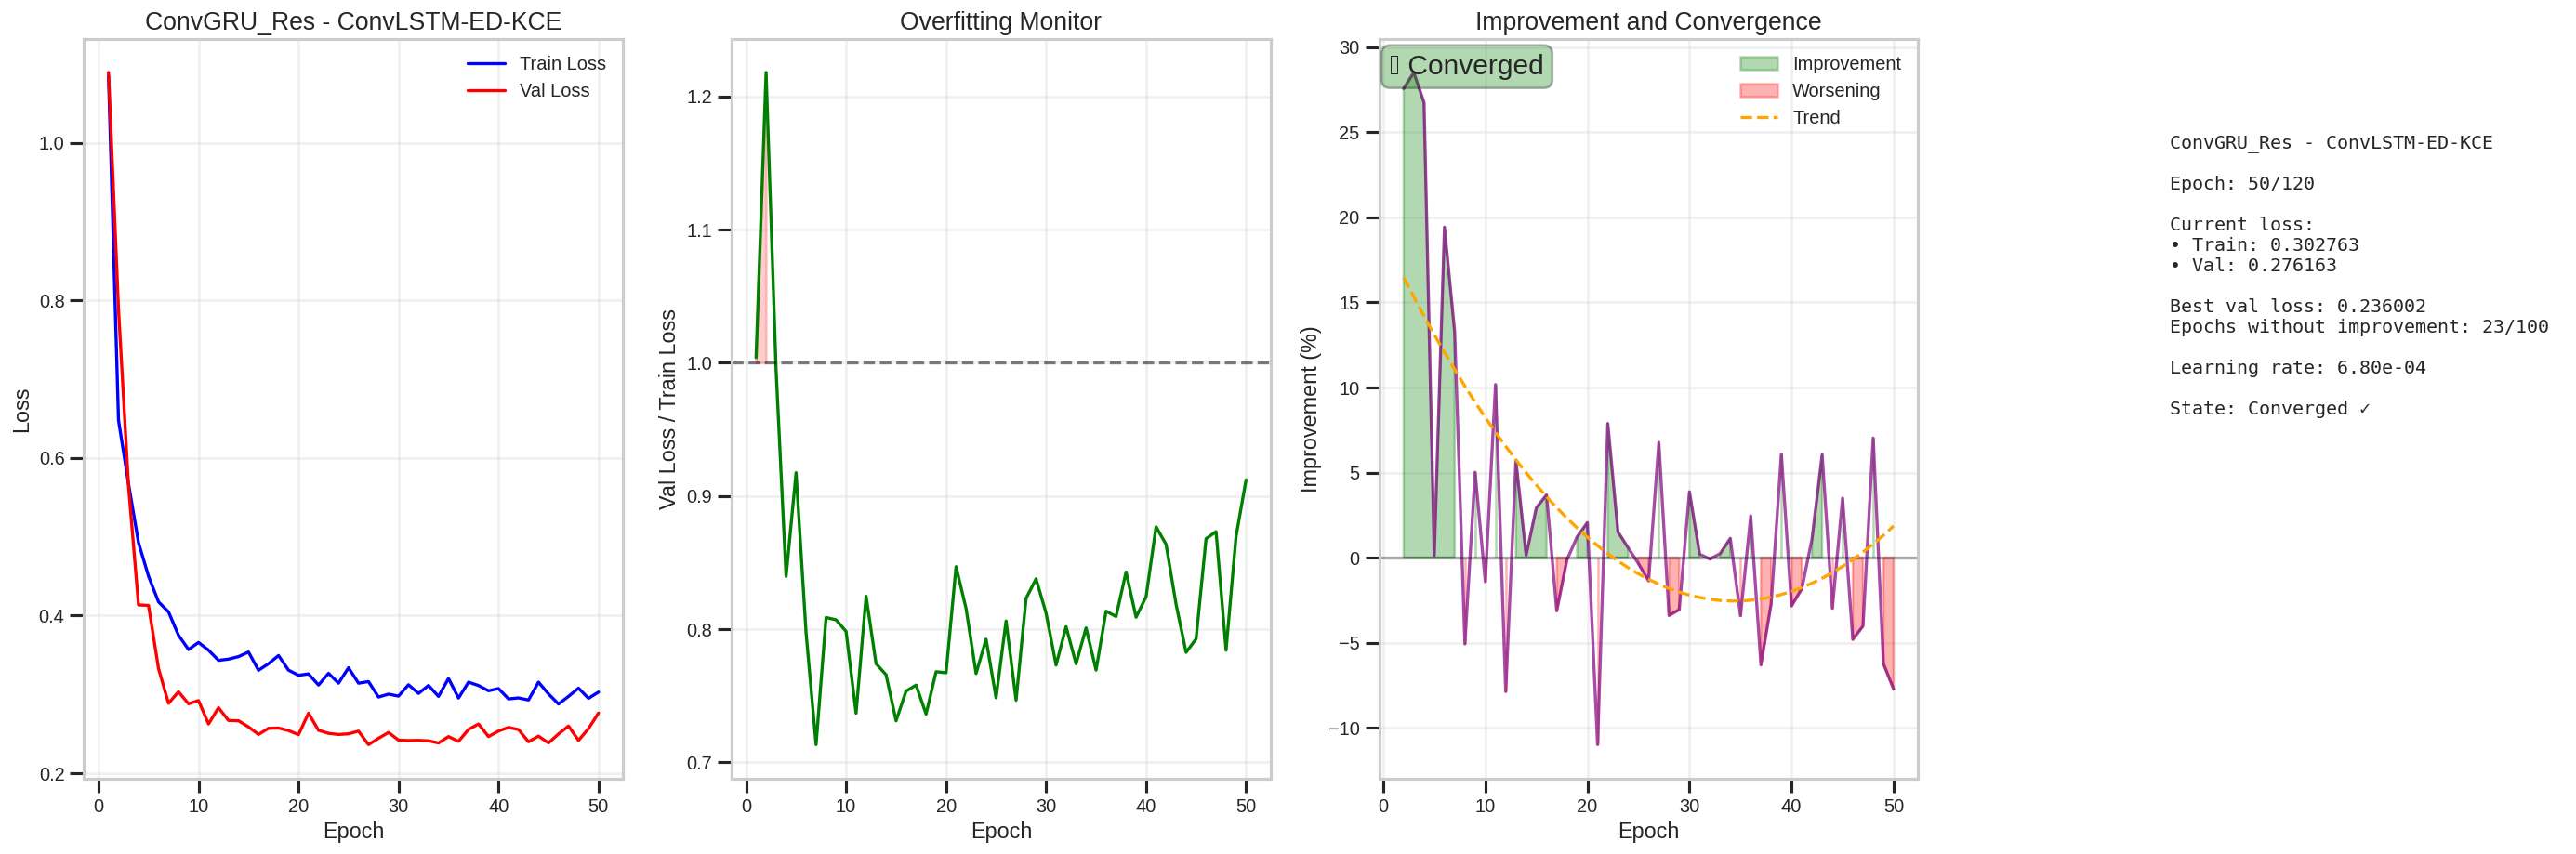

In [ ]:
# ───────────────────────── TRAIN + EVAL LOOP ─────────────────────────

# Dictionary for storing training histories
all_histories = {}
results = []

for exp_name, exp_cfg in EXPERIMENTS.items():

    # Ensure the experiment is active (based on the original definition)
    if not exp_cfg.get('active', True): # Safely get 'active', default to True if missing
         print(f"\nSkipping inactive experiment: {exp_name}")
         continue

    feat_list = exp_cfg['feature_list'] # Get the list of feature names
    print(f"\n{'='*70}")
    print(f"🔬 EXPERIMENT: {exp_name} ({len(feat_list)} features)")
    print(f"{'='*70}")

    # Prepare data
    Xarr = ds[feat_list].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds['total_precipitation'].values.astype(np.float32)[...,None]
    X, y = windowed_arrays(Xarr, yarr)
    split = int(0.8*len(X))
    val_split = int(0.9*len(X))

    # Normalization
    sx = StandardScaler().fit(X[:split].reshape(-1,len(feat_list)))
    sy = StandardScaler().fit(y[:split].reshape(-1,1))
    X_sc = sx.transform(X.reshape(-1,len(feat_list))).reshape(X.shape)
    y_sc = sy.transform(y.reshape(-1,1)).reshape(y.shape)

    # Splits
    X_tr, X_va, X_te = X_sc[:split], X_sc[split:val_split], X_sc[val_split:]
    y_tr, y_va, y_te = y_sc[:split], y_sc[split:val_split], y_sc[val_split:]

    print(f"   Datos: Train={len(X_tr)}, Val={len(X_va)}, Test={len(X_te)}")

    OUT_EXP = OUT_ROOT/exp_name
    OUT_EXP.mkdir(exist_ok=True)

    # Create subdirectory for training metrics
    METRICS_DIR = OUT_EXP / 'training_metrics'
    METRICS_DIR.mkdir(exist_ok=True)

    for mdl_name, builder in ADVANCED_MODELS.items():
        print(f"\n{'─'*50}")
        print(f"🤖 Modelo: {mdl_name}")
        print(f"{'─'*50}")

        model_path = OUT_EXP/f"{mdl_name.lower()}_best.keras"
        if model_path.exists():
            model_path.unlink()

        try:
            # Build model
            model = builder(n_feats=len(feat_list))

            # Define optimizer with explicit configuration
            optimizer = AdamW(learning_rate=LR, weight_decay=L2_REG)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Hyperparameters
            hyperparams = {
                'experiment': exp_name,
                'model': mdl_name,
                'features': [str(f) for f in feat_list],  # Convert to strings
                'n_features': int(len(feat_list)),
                'input_window': int(INPUT_WINDOW),
                'horizon': int(HORIZON),
                'batch_size': int(BATCH_SIZE),
                'initial_lr': float(LR),
                'epochs': int(EPOCHS),
                'patience': int(PATIENCE),
                'dropout': float(DROPOUT),
                'l2_reg': float(L2_REG),
                'train_samples': int(len(X_tr)),
                'val_samples': int(len(X_va)),
                'test_samples': int(len(X_te)),
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'model_params': int(model.count_params())
            }

            # Save hyperparameters
            save_hyperparameters(METRICS_DIR, mdl_name, hyperparams)

            # Callbacks
            callbacks = create_callbacks(mdl_name, exp_name, model_path)

            # Train with verbose=0 to use our custom monitor
            print(f"\n🏃 Iniciando entrenamiento...")
            print(f"   📊 Visualización en tiempo real activada")
            print(f"   📈 Parámetros del modelo: {model.count_params():,}")

            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=callbacks,
                verbose=0  # Use 0 to only show our custom monitor
            )

            # Save history
            all_histories[f"{exp_name}_{mdl_name}"] = history

            # Show training summary
            print_training_summary(history, mdl_name, exp_name)

            # Plot and save learning curves
            plot_learning_curves(history, METRICS_DIR, mdl_name, show=True)

            # Save history as JSON
            # Get learning rates from training monitor if not in history
            training_monitor = [cb for cb in callbacks if isinstance(cb, AdvancedTrainingMonitor)][0]
            lr_values = history.history.get('lr', [])
            if not lr_values and hasattr(training_monitor, 'history'):
                lr_values = training_monitor.history['lr']

            history_dict = {
                'loss': [float(x) for x in history.history['loss']],
                'val_loss': [float(x) for x in history.history['val_loss']],
                'mae': [float(x) for x in history.history.get('mae', [])],
                'val_mae': [float(x) for x in history.history.get('val_mae', [])],
                'lr': [float(x) for x in lr_values] if lr_values else []
            }

            with open(METRICS_DIR / f"{mdl_name}_history.json", 'w') as f:
                json.dump(history_dict, f, indent=4)

            # ─ Evaluation on Test Set ─
            print(f"\n📊 Evaluating on test set...")
            test_loss, test_mae = model.evaluate(X_te, y_te, verbose=0)
            print(f"   Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

            # ─ Predictions and visualization ─
            print(f"\n🎯 Generating predictions...")
            # Use the first 5 samples of the test set
            sample_indices = min(5, len(X_te))
            y_hat_sc = model.predict(X_te[:sample_indices], verbose=0)
            y_hat = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(-1,HORIZON,lat,lon)
            y_true = sy.inverse_transform(y_te[:sample_indices].reshape(-1,1)).reshape(-1,HORIZON,lat,lon)

            # ─ Evaluation metrics by horizon ─
            # Define forecast dates for visualization
            forecast_dates = pd.date_range(ds.time.values[-HORIZON], periods=HORIZON, freq='MS')

            for h in range(HORIZON):
                rmse = np.sqrt(mean_squared_error(y_true[:,h].ravel(), y_hat[:,h].ravel()))
                mae = mean_absolute_error(y_true[:,h].ravel(), y_hat[:,h].ravel())
                r2 = r2_score(y_true[:,h].ravel(), y_hat[:,h].ravel())

                # Get horizon date for this forecast step
                horizon_date = forecast_dates[h].strftime('%Y-%m')

                results.append({
                    'Experiment': exp_name,
                    'Model': mdl_name,
                    'horizon': horizon_date,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'Test_Loss': test_loss,
                    'Parameters': model.count_params()
                })

                print(f"   📈 {horizon_date}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

            # ─ Maps & GIF ─
            print(f"\n🎨 Generating visualizations...")
            # Use the first sample for visualization
            sample_idx = 0
            vmin, vmax = 0, max(y_true[sample_idx].max(), y_hat[sample_idx].max())
            frames = []
            # Use the previously defined forecast_dates variable

            for h in range(HORIZON):
                err = np.clip(np.abs((y_true[sample_idx,h]-y_hat[sample_idx,h])/(y_true[sample_idx,h]+1e-5))*100, 0, 100)
                try:
                    import cartopy.crs as ccrs
                    fig, axs = plt.subplots(1, 3, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
                except ImportError:
                    fig, axs = plt.subplots(1, 3, figsize=(20, 8))

                # Real
                real_mesh = axs[0].pcolormesh(ds.longitude, ds.latitude, y_true[sample_idx,h],
                                            cmap='Blues', shading='nearest', vmin=vmin, vmax=vmax,
                                            transform=ccrs.PlateCarree())
                axs[0].coastlines()
                axs[0].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                    edgecolor='black', facecolor='none', linewidth=1)
                axs[0].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[0].set_title(f"Real {forecast_dates[h].strftime('%Y-%m')}", fontsize=11)
                real_cbar = fig.colorbar(real_mesh, ax=axs[0], fraction=0.046, pad=0.04)
                real_cbar.set_label('Precipitation (mm)', rotation=270, labelpad=15)

                # Prediction
                pred_mesh = axs[1].pcolormesh(ds.longitude, ds.latitude, y_hat[sample_idx,h],
                                            cmap='Blues', shading='nearest', vmin=vmin, vmax=vmax,
                                            transform=ccrs.PlateCarree())
                axs[1].coastlines()
                axs[1].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                     edgecolor='black', facecolor='none', linewidth=1)
                axs[1].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[1].set_title(f"{mdl_name} {forecast_dates[h].strftime('%Y-%m')}", fontsize=11)
                pred_cbar = fig.colorbar(pred_mesh, ax=axs[1], fraction=0.046, pad=0.04)
                pred_cbar.set_label('Precipitation (mm)', rotation=270, labelpad=15)

                # Error
                err_mesh = axs[2].pcolormesh(ds.longitude, ds.latitude, err,
                                           cmap='Reds', shading='nearest', vmin=0, vmax=100,
                                           transform=ccrs.PlateCarree())
                axs[2].coastlines()
                axs[2].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                    edgecolor='black', facecolor='none', linewidth=1)
                axs[2].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[2].set_title(f"MAPE% {forecast_dates[h].strftime('%Y-%m')}", fontsize=11)
                err_cbar = fig.colorbar(err_mesh, ax=axs[2], fraction=0.046, pad=0.04)
                err_cbar.set_label('MAPE (%)', rotation=270, labelpad=15)

                fig.suptitle(f"{mdl_name} – {exp_name} – {forecast_dates[h].strftime('%Y-%m')}", fontsize=13)
                horizon_date = forecast_dates[h].strftime('%Y-%m')
                png = OUT_EXP/f"{mdl_name}_{horizon_date}.png"
                fig.tight_layout()
                fig.savefig(png, dpi=700, bbox_inches='tight')
                plt.close(fig)
                frames.append(imageio.imread(png))

            imageio.mimsave(OUT_EXP/f"{mdl_name}.gif", frames, fps=0.5)
            print(f"   ✅ GIF saved: {OUT_EXP/f'{mdl_name}.gif'}")

            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"  ⚠️ Error in {mdl_name}: {str(e)}")
            print(f"  → Skipping {mdl_name} for {exp_name}")
            import traceback
            traceback.print_exc()
            continue

# ───────────────────────── CSV FINAL ─────────────────────────
res_df = pd.DataFrame(results)
res_df.to_csv(OUT_ROOT/'metrics_advanced.csv', index=False)
print("\n📑 Metrics saved →", OUT_ROOT/'metrics_advanced.csv')


In [ ]:
# ───────────────────────── COMPARATIVE VISUALIZATION ─────────────────────────
print("\n" + "="*70)
print("📊 GENERATING COMPARATIVE VISUALIZATIONS")
print("="*70)

# Create directory for comparisons
COMP_DIR = OUT_ROOT / "comparisons"
COMP_DIR.mkdir(exist_ok=True)

# 1. Comparison of metrics between models
if "res_df" in locals() and not res_df.empty:
    sns.set(style="ticks", context="paper", font_scale=1.2)

    fig, axes = plt.subplots(2, 2, figsize=(24, 16))

    # ---------- RMSE ----------
    (res_df
     .pivot_table(values="RMSE", index="Model", columns="Experiment", aggfunc="mean")
     .plot(kind="bar", ax=axes[0, 0]))
    axes[0, 0].set(title="RMSE Average by Model and Experiment",
                   ylabel="RMSE (mm)", xlabel="")
    axes[0, 0].legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    axes[0, 0].grid(alpha=.3)
    axes[0, 0].tick_params(axis="x", rotation=45)

    # ---------- MAE ----------
    (res_df
     .pivot_table(values="MAE", index="Model", columns="Experiment", aggfunc="mean")
     .plot(kind="bar", ax=axes[0, 1]))
    axes[0, 1].set(title="MAE Average by Model and Experiment",
                   ylabel="MAE (mm)", xlabel="")
    axes[0, 1].legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    axes[0, 1].grid(alpha=.3)
    axes[0, 1].tick_params(axis="x", rotation=45)

    # ---------- R² ----------
    (res_df
     .pivot_table(values="R2", index="Model", columns="Experiment", aggfunc="mean")
     .plot(kind="bar", ax=axes[1, 0]))
    axes[1, 0].set(title="R² Average by Model and Experiment",
                   ylabel="R²", xlabel="")
    axes[1, 0].legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    axes[1, 0].grid(alpha=.3)
    axes[1, 0].tick_params(axis="x", rotation=45)

        # ---------- Horizon evolution ----------
    ax_h = axes[1, 1]

    # Get unique horizons from the data
    horizons = sorted(res_df['horizon'].unique())

    for model, grp in res_df.groupby("Model"):
        (grp.groupby("horizon")["RMSE"].mean()
             .sort_index()  # keep chronological order
             .plot(ax=ax_h, marker="o",
                   linewidth=2.5, markersize=8, label=model))

    ax_h.set(title="Evolution of RMSE by Horizon",
             xlabel="", ylabel="RMSE (mm)")

    # use the mapped labels on x-axis
    # Fix: Use the index of the horizons for xticks
    ax_h.set_xticks(range(len(horizons)))
    ax_h.set_xticklabels(horizons, rotation=45)
    ax_h.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    ax_h.grid(alpha=.3)

    sns.despine()
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    out_path = IMAGE_DIR / "advanced_models_plot.png"
    plt.savefig(out_path, dpi=700, bbox_inches="tight")
    plt.show()
    print(f"✅ Figure saved → {out_path}")

# 2. Summary table of best models
if "res_df" in locals() and not res_df.empty:
    print("\n📋 SUMMARY TABLE – BEST MODELS BY EXPERIMENT")
    print("─" * 60)
    best_models = (res_df
                   .loc[res_df.groupby("Experiment")["RMSE"].idxmin(),
                        ["Experiment", "Model", "RMSE", "MAE", "R2"]]
                   .set_index("Experiment"))
    print(best_models.to_string())

# 3. Comparison with original models if available
old_metrics_path = OUT_ROOT.parent / "Spatial_CONVRNN" / "metrics_spatial.csv"
if old_metrics_path.exists():
    print("\n📊 COMPARISON WITH ORIGINAL MODELS")
    print("─" * 60)
    old_df = pd.read_csv(old_metrics_path)

    if "res_df" in locals() and not res_df.empty:
        for exp in EXPERIMENTS.keys():
            new_data = res_df[res_df["Experiment"] == exp]
            old_data = old_df[old_df["Experiment"] == exp]

            if new_data.empty or old_data.empty:
                continue

            new_best = (new_data.groupby("Model")["RMSE"].mean()
                        .idxmin())
            new_rmse = new_data[new_data["Model"] == new_best]["RMSE"].mean()
            old_best_rmse = old_data["RMSE"].min()
            imp = (old_best_rmse - new_rmse) / old_best_rmse * 100

            print(f"\n{exp}:")
            print(f"  • Best new model: {new_best} (RMSE {new_rmse:.2f})")
            print(f"  • Best original RMSE: {old_best_rmse:.2f}")
            print(f"  • Improvement: {imp:.2f}%")

print("\n✅ Comparative visualizations completed.")
print(f"📂 All outputs stored in: {COMP_DIR}")


In [ ]:
# ───────────────────────── DETAILED ANALYSIS OF RESULTS ─────────────────────────
if "res_df" in locals() and not res_df.empty:
    print("\n" + "="*70)
    print("📊 DETAILED ANALYSIS OF RESULTS")
    print("="*70)

    # ------------------------------------------------------------------ #
    # 1. Metrics vs horizon  (three panels: RMSE / MAE / R²)
    # ------------------------------------------------------------------ #
    import seaborn as sns, matplotlib.pyplot as plt, numpy as np

    # Get the horizon dates from the data
    month_order = sorted(res_df["horizon"].unique())

    fig, axes = plt.subplots(1, 3, figsize=(24, 9), sharex=True)
    sns.set(style="ticks", context="paper", font_scale=1.2)

    metrics   = ["RMSE", "MAE", "R2"]
    y_labels  = ["RMSE (mm)", "MAE (mm)", "R²"]
    colors    = plt.cm.Set3(np.linspace(0, 1, res_df["Model"].nunique()))

    for idx, (metric, ylab) in enumerate(zip(metrics, y_labels)):
        ax  = axes[idx]
        piv = (res_df
               .groupby(["horizon", "Model"])[metric]
               .mean()
               .unstack())

        # Ensure chronological order
        piv = piv.loc[month_order]

        for i, model in enumerate(piv.columns):
            ax.plot(piv.index, piv[model],
                    marker="o", linewidth=2.5, markersize=8,
                    color=colors[i], label=model)

        ax.set_ylabel(ylab)
        ax.set_xlabel("")
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
        ax.grid(alpha=.3, linestyle="--")
        ax.tick_params(axis="x", rotation=45)

    sns.despine()
    plt.tight_layout()
    plt.savefig(IMAGE_DIR / "advanced_models_plot.png",
                dpi=700, bbox_inches="tight")
    plt.show()

    # 2. Visual table of metrics
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.axis('tight')
    ax.axis('off')

    # Prepare data for the table
    summary_data = []
    experiments = res_df['Experiment'].unique()
    models = res_df['Model'].unique()

    # Headers
    headers = ['Experimento', 'Modelo', 'RMSE↓', 'MAE↓', 'R²↑', 'Mejor H', 'Parámetros']

    for exp in experiments:
        for model in models:
            exp_model_data = res_df[(res_df['Experiment'] == exp) & (res_df['Model'] == model)]
            if not exp_model_data.empty:
                avg_rmse = exp_model_data['RMSE'].mean()
                avg_mae = exp_model_data['MAE'].mean()
                avg_r2 = exp_model_data['R2'].mean()
                best_h = exp_model_data.loc[exp_model_data['RMSE'].idxmin(), 'horizon']
                params = exp_model_data['Parameters'].iloc[0]

                summary_data.append([
                    exp, model,
                    f'{avg_rmse:.4f}',
                    f'{avg_mae:.4f}',
                    f'{avg_r2:.4f}',
                    f'H={best_h}',
                    f'{params:,}'
                ])

    # Create table
    table = ax.table(cellText=summary_data, colLabels=headers,
                    cellLoc='center', loc='center')

    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    # Color cells according to performance
    for i in range(len(summary_data)):
        # Get values for comparison
        rmse_val = float(summary_data[i][2])
        mae_val = float(summary_data[i][3])
        r2_val = float(summary_data[i][4])

        # Find min/max for normalization
        all_rmse = [float(row[2]) for row in summary_data]
        all_mae = [float(row[3]) for row in summary_data]
        all_r2 = [float(row[4]) for row in summary_data]

        # Normalize and color RMSE (lower is better)
        rmse_norm = (rmse_val - min(all_rmse)) / (max(all_rmse) - min(all_rmse))
        rmse_color = plt.cm.RdYlGn(1 - rmse_norm)
        table[(i+1, 2)].set_facecolor(rmse_color)

        # Normalize and color MAE (lower is better)
        mae_norm = (mae_val - min(all_mae)) / (max(all_mae) - min(all_mae))
        mae_color = plt.cm.RdYlGn(1 - mae_norm)
        table[(i+1, 3)].set_facecolor(mae_color)

        # Normalize and color R² (higher is better)
        r2_norm = (r2_val - min(all_r2)) / (max(all_r2) - min(all_r2))
        r2_color = plt.cm.RdYlGn(r2_norm)
        table[(i+1, 4)].set_facecolor(r2_color)

        # Color experiment
        exp_colors = {'BASIC': '#e8f4f8', 'KCE': '#f0e8f8', 'PAFC': '#f8e8f0'}
        table[(i+1, 0)].set_facecolor(exp_colors.get(summary_data[i][0], 'white'))

    # Color headers
    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    plt.title('Summary of Metrics by Model and Experiment\n(Green=Best, Red=Worst)',
             fontsize=16, fontweight='bold', pad=20)

    # Add legend
    plt.text(0.5, -0.05, '↓ = Lower is better, ↑ = Higher is better',
            transform=ax.transAxes, ha='center', fontsize=10, style='italic')

    plt.savefig(IMAGE_DIR/f"advanced_models_metrics.png", dpi=700, bbox_inches='tight')
    plt.show()

    # 3. Identify the best global model
    print("\n🏆 BEST GLOBAL MODEL:")
    print("─" * 50)

    # Calculate composite score (normalized)
    res_df['score'] = (
        (1 - (res_df['RMSE'] - res_df['RMSE'].min()) / (res_df['RMSE'].max() - res_df['RMSE'].min())) +
        (1 - (res_df['MAE'] - res_df['MAE'].min()) / (res_df['MAE'].max() - res_df['MAE'].min())) +
        ((res_df['R2'] - res_df['R2'].min()) / (res_df['R2'].max() - res_df['R2'].min()))
    ) / 3

    best_overall = res_df.loc[res_df['score'].idxmax()]
    print(f"Model: {best_overall['Model']}")
    print(f"Experiment: {best_overall['Experiment']}")
    print(f"Horizon: {best_overall['horizon']}")
    print(f"RMSE: {best_overall['RMSE']:.4f}")
    print(f"MAE: {best_overall['MAE']:.4f}")
    print(f"R²: {best_overall['R2']:.4f}")
    print(f"Composite score: {best_overall['score']:.4f}")

    # 4. Analysis of improvement by horizon
    print("\n📈 ANALYSIS OF IMPROVEMENT BY HORIZON:")
    print("─" * 50)

    for h in sorted(res_df['horizon'].unique()):
        h_data = res_df[res_df['horizon'] == h]
        best_h = h_data.loc[h_data['RMSE'].idxmin()]

        print(f"\nHorizon {h}:")
        print(f"  • Best model: {best_h['Model']} - {best_h['Experiment']}")
        print(f"  • RMSE: {best_h['RMSE']:.4f}")
        print(f"  • R²: {best_h['R2']:.4f}")

print("\n✅ Detailed analysis completed!")


In [ ]:
# ───────────────────────── SHOW RECENT PREDICTIONS ─────────────────────────
print("\n🖼️ RECENT PREDICTIONS:")
for exp in EXPERIMENTS.keys():
    exp_dir = OUT_ROOT / exp
    if exp_dir.exists():
        print(f"\n{exp}:")
        # Show first image of each model
        for model in ADVANCED_MODELS.keys():
            # Try to find an image with a date-based filename
            img_files = list(exp_dir.glob(f"{model}_*.png"))
            img_path = img_files[0] if img_files else None
            gif_path = exp_dir / f"{model}.gif"

            if img_path and img_path.exists():
                from IPython.display import Image, display
                # Extract date from filename if possible
                date_str = img_path.stem.split('_')[-1] if '_' in img_path.stem else 'first month'
                print(f"  {model} - Prediction for {date_str}:")
                display(Image(str(img_path), width=800))

            if gif_path.exists():
                print(f"  📹 GIF available: {gif_path}")

print("\n" + "="*70)
print("🎉 NOTEBOOK COMPLETED!")
print("="*70)
print(f"\n📊 Resultados guardados en: {OUT_ROOT}")
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print(f"📈 Metrics in: {OUT_ROOT/'metrics_advanced.csv'}")
    print(f"🖼️ Visualizations in: {COMP_DIR if 'COMP_DIR' in locals() else 'N/A'}")
else:
    print("⚠️ No metrics generated in this execution")
print("\n💡 Next steps:")
print("   1. Review the metrics and select the best model")
print("   2. Fine-tune hyperparameters if necessary")
print("   3. Train an ensemble with the best models")
print("   4. Evaluate on more recent or different regions")


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  MASTER FIX  —  custom layers, carga robusta y log de errores       ║
# ╚══════════════════════════════════════════════════════════════════════╝
from pathlib import Path
import sys, gc, traceback, json, warnings
import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, utils

warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────────────
# 1)  CAPAS PERSONALIZADAS (visibles para TODO el runtime)
# ──────────────────────────────────────────────────────────────────────
try:  # Keras 3 / TF >= 2.15
    from tensorflow.keras.saving import register_keras_serializable as _reg
except ImportError:
    from tensorflow.keras.utils import register_keras_serializable as _reg

@_reg()  # id = "ConvGRU2D"
class ConvGRU2D(layers.Layer):
    def __init__(self, filters, kernel_size, padding="same",
                 activation="tanh", recurrent_activation="sigmoid",
                 return_sequences=True, use_batch_norm=True, dropout=0.2, **kw):
        super().__init__(**kw)
        self.filters, self.kernel_size, self.padding = filters, kernel_size, padding
        self.activation, self.recurrent_activation = activation, recurrent_activation
        self.return_sequences, self.use_batch_norm, self.dropout = \
            return_sequences, use_batch_norm, dropout
        self.supports_masking = True

    def build(self, shape):
        self.gru = layers.ConvLSTM2D(self.filters, self.kernel_size,
                                     padding=self.padding,
                                     activation=self.activation,
                                     recurrent_activation=self.recurrent_activation,
                                     return_sequences=self.return_sequences)
        if self.use_batch_norm:
            self.bn = layers.BatchNormalization()
        if self.dropout:
            self.do = layers.Dropout(self.dropout)
        super().build(shape)

    def call(self, x, training=None):
        x = self.gru(x, training=training)
        if self.use_batch_norm:
            x = self.bn(x, training=training)
        if training and self.dropout:
            x = self.do(x, training=training)
        return x

    def get_config(self):
        cfg = super().get_config()
        cfg.update({k: getattr(self, k) for k in (
            "filters", "kernel_size", "padding", "activation",
            "recurrent_activation", "return_sequences",
            "use_batch_norm", "dropout")})
        return cfg

@_reg()  # id = "CBAM"
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8, **kw):
        super().__init__(**kw); self.reduction_ratio = reduction_ratio

    def build(self, shape):
        ch = shape[-1]
        self.mlp = tf.keras.Sequential([
            layers.Dense(ch // self.reduction_ratio, activation="relu"),
            layers.Dense(ch, activation="sigmoid")
        ])
        self.spatial = layers.Conv2D(1, 7, padding="same", activation="sigmoid")
        super().build(shape)

    def call(self, x):
        # channel att
        avg = tf.reduce_mean(x, [1,2], keepdims=True)
        max_ = tf.reduce_max(x, [1,2], keepdims=True)
        x = x * (self.mlp(avg) + self.mlp(max_))
        # spatial att
        avg = tf.reduce_mean(x, -1, keepdims=True)
        max_ = tf.reduce_max(x, -1, keepdims=True)
        x = x * self.spatial(tf.concat([avg, max_], -1))
        return x

    # necesarios para TimeDistributed
    def compute_output_shape(self, s): return s
    def compute_output_signature(self, sig): return sig

    def get_config(self):
        cfg = super().get_config(); cfg.update({"reduction_ratio": self.reduction_ratio}); return cfg

# Aliases (por si el modelo fue grabado con otra mayúscula/minúscula)
aliases = {
    "conv_gru2d": ConvGRU2D, "cbam": CBAM,
    "CustomLayers>ConvGRU2D": ConvGRU2D, "CustomLayers>CBAM": CBAM,
}
utils.get_custom_objects().update({"ConvGRU2D": ConvGRU2D, "CBAM": CBAM, **aliases})
setattr(layers, "ConvGRU2D", ConvGRU2D); setattr(layers, "CBAM", CBAM)

print("✅ Custom layers registradas:", list(utils.get_custom_objects().keys() & {"ConvGRU2D","CBAM"}))

# ──────────────────────────────────────────────────────────────────────
# 2)  LOG centralizado de errores (export_errors.txt)
# ──────────────────────────────────────────────────────────────────────
# ╔══════════════════════════════════════════════════════════════╗
# ║        FIX DEFINITIVO: load_model_safe + log de errores      ║
# ╚══════════════════════════════════════════════════════════════╝
import tensorflow as tf, traceback, sys, gc
from pathlib import Path
from tensorflow.keras import utils

# Directorio y archivo de log (usa el ya creado por tu script)
META_MODELS_DIR = OUT_ROOT / "meta_models"
META_MODELS_DIR.mkdir(exist_ok=True)
ERRORS_LOG = META_MODELS_DIR / "export_errors.txt"
ERRORS_LOG.write_text("")  # limpia al arrancar

def _log(context: str, exc: BaseException):
    tb = "".join(traceback.format_exception(type(exc), exc, exc.__traceback__))
    block = f"\n╭─ {context} ─────────────────────────────────────────\n{tb}╰───────────────────────────────────────────────────────────\n"
    print(block, file=sys.stderr)
    with open(ERRORS_LOG, "a") as f:
        f.write(block)

def load_model_safe(model_path: Path, model_name: str = None):
    """Carga robusta (.keras / .h5) con capas personalizadas y registra
       tracebacks completos en export_errors.txt."""
    nm = model_name or model_path.name
    try:
        with tf.keras.utils.custom_object_scope(utils.get_custom_objects()):
            model = tf.keras.models.load_model(
                model_path,
                custom_objects=utils.get_custom_objects(),
                compile=False,
                safe_mode=False,   # necesario si hay Lambda layers serializados
            )
        print(f"      ✅ Loaded {nm} (safe_mode=False)")
        return model
    except Exception as e:
        _log(f"load_model({nm})", e)

    # Fallback: archivos separados .json + .h5
    try:
        arch, wts = model_path.with_suffix(".json"), model_path.with_suffix(".h5")
        if arch.exists() and wts.exists():
            with open(arch) as f:
                model = tf.keras.models.model_from_json(
                    f.read(), custom_objects=utils.get_custom_objects())
            model.load_weights(wts)
            print(f"      ⚡ Loaded {nm} from split files")
            return model
    except Exception as e2:
        _log(f"split‑files({nm})", e2)

    tf.keras.backend.clear_session(); gc.collect()
    print(f"      ❌ All loading methods failed for {nm}")
    return None

print("🔧 load_model_safe actualizado (firma: path, model_name=None) y logging listo.")

In [ ]:
# 📁 BEST MODELS PREDICTIONS EXPORT FOR META-MODELS
# ════════════════════════════════════════════════════════════════════════════════
#
# ⬇️  **Esta versión corrige el AttributeError** que impedía registrar las capas
#     personalizadas.  Añadimos un import compatible con cualquier versión de
#     TensorFlow 2.x y sustituimos los decoradores problemáticos.
#

import numpy as np
import tensorflow as tf
from pathlib import Path
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import gc, warnings
warnings.filterwarnings('ignore')

print("🚀 STARTING BEST MODELS PREDICTIONS EXPORT...")
print("="*70)

# --------------------------------------------------------------------------------
# 1) DIRECTORIO PARA EXPORTES
# --------------------------------------------------------------------------------
META_MODELS_DIR = OUT_ROOT / 'meta_models'
META_MODELS_DIR.mkdir(exist_ok=True)
print(f"📂 Meta-models directory: {META_MODELS_DIR}")

# --------------------------------------------------------------------------------
# 2) COMPATIBILIDAD PARA register_keras_serializable
# --------------------------------------------------------------------------------
try:
    # Keras 3 / TF ≥ 2.15
    from tensorflow.keras.saving import register_keras_serializable as register_ks
except ImportError:
    # TF 2.x anteriores
    from tensorflow.keras.utils import register_keras_serializable as register_ks

# Registro global de objetos personalizados
CUSTOM_OBJECTS = utils.get_custom_objects()   # usa las de la primera celda

# --------------------------------------------------------------------------------
# 4) … EL RESTO DE LA CELDA QUEDA IGUAL …
#     (load_best_combinations, load_model_safe, export_best_predictions, etc.)
# --------------------------------------------------------------------------------

def load_best_combinations():
    """Load and identify the best 2 model-experiment combinations"""

    # Try to load existing metrics
    metrics_file = OUT_ROOT / 'metrics_advanced.csv'
    if not metrics_file.exists():
        print("⚠️ No metrics file found. Please run training first.")
        return []

    # Load metrics and find best combinations
    df = pd.read_csv(metrics_file)

    # Calculate average performance across horizons for each model-experiment pair
    summary = df.groupby(['Experiment', 'Model']).agg({
        'RMSE': 'mean',
        'MAE': 'mean',
        'R2': 'mean',
        'Parameters': 'first'
    }).reset_index()

    # Sort by RMSE (lower is better) and R2 (higher is better)
    summary['Score'] = summary['R2'] - (summary['RMSE'] / summary['RMSE'].max())
    summary = summary.sort_values('Score', ascending=False)

    print(f"📊 Model Performance Summary (Top 10):")
    print(summary.head(10)[['Experiment', 'Model', 'RMSE', 'MAE', 'R2', 'Score']].to_string(index=False))

    # Select top 2 combinations ensuring no model repetition
    selected = []
    used_models = set()

    for _, row in summary.iterrows():
        if row['Model'] not in used_models and len(selected) < 2:
            selected.append({
                'experiment': row['Experiment'],
                'model': row['Model'],
                'rmse': row['RMSE'],
                'mae': row['MAE'],
                'r2': row['R2'],
                'score': row['Score'],
                'parameters': row['Parameters']
            })
            used_models.add(row['Model'])

    print(f"\n🎯 SELECTED TOP 2 COMBINATIONS:")
    for i, combo in enumerate(selected, 1):
        print(f"   {i}. {combo['experiment']} + {combo['model']} (Score: {combo['score']:.4f})")

    return selected

def load_model_safe(path):
    """Carga robusta de modelos con Lambda y custom layers."""
    import tensorflow as tf, gc
    try:
        # ①  Intento principal (safe_mode=False + custom_objects)
        with tf.keras.utils.custom_object_scope(utils.get_custom_objects()):
            model = tf.keras.models.load_model(
                path,
                custom_objects=utils.get_custom_objects(),
                compile=False,
                safe_mode=False,   #  ← desactiva las restricciones de Lambda
            )
        print("      ✅ Loaded with safe_mode=False")
        return model
    except Exception as e:
        print("      ⚠️  load_model failed:", e)

    # ②  Última alternativa: sólo arquitectura, luego pesos
    try:
        arch_json = Path(path).with_suffix(".json")
        weights_h5 = Path(path).with_suffix(".h5")
        if arch_json.exists() and weights_h5.exists():
            with open(arch_json) as f:
                model = tf.keras.models.model_from_json(
                    f.read(), custom_objects=utils.get_custom_objects())
            model.load_weights(weights_h5)
            print("      ⚡ Loaded from split architecture/weights")
            return model
    except Exception as e2:
        print("      ⚠️  split‑files fallback failed:", e2)

    tf.keras.backend.clear_session(); gc.collect()
    print("      ❌ All loading methods failed")
    return None


def export_best_predictions():
    """Export predictions from the best model-experiment combinations"""

    # Get best combinations
    best_combos = load_best_combinations()

    if len(best_combos) == 0:
        print("❌ No valid combinations found!")
        return False

    exported_models = []

    for i, combo in enumerate(best_combos, 1):
        exp_name = combo['experiment']
        model_name = combo['model']

        print(f"\n" + "─"*60)
        print(f"🎯 EXPORTING {i}/2: {exp_name} + {model_name}")
        print(f"   📊 Score: {combo['score']:.4f} | RMSE: {combo['rmse']:.4f} | R²: {combo['r2']:.4f}")
        print("─"*60)

        # Check if experiment configuration exists
        if exp_name not in EXPERIMENTS:
            print(f"   ❌ Experiment {exp_name} not found in EXPERIMENTS")
            continue

        exp_cfg = EXPERIMENTS[exp_name]
        feat_list = exp_cfg['feature_list']

        # Check if model file exists
        model_path = OUT_ROOT / exp_name / f"{model_name.lower()}_best.keras"
        if not model_path.exists():
            print(f"   ❌ Model file not found: {model_path}")
            # Try alternative naming patterns
            alt_patterns = [
                OUT_ROOT / exp_name / f"{model_name}_best.keras",
                OUT_ROOT / exp_name / f"{model_name.lower()}.keras",
                OUT_ROOT / exp_name / f"{model_name}.keras"
            ]

            for alt_path in alt_patterns:
                if alt_path.exists():
                    model_path = alt_path
                    print(f"   ✅ Found alternative: {model_path}")
                    break
            else:
                print(f"   📁 Available files in {OUT_ROOT / exp_name}:")
                exp_dir = OUT_ROOT / exp_name
                if exp_dir.exists():
                    for file in exp_dir.glob("*"):
                        print(f"      📄 {file.name}")
                continue

        try:
            # Prepare data for this experiment
            print("   📥 Preparing data...")

            # Validate that required variables exist
            if 'ds' not in globals():
                print("   ❌ Dataset 'ds' not found in global scope")
                continue

            if 'windowed_arrays' not in globals():
                print("   ❌ Function 'windowed_arrays' not found in global scope")
                continue

            # Prepare features array
            try:
                Xarr = ds[feat_list].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
                yarr = ds['total_precipitation'].values.astype(np.float32)[...,None]
                X, y = windowed_arrays(Xarr, yarr)
            except Exception as data_error:
                print(f"   ❌ Data preparation failed: {data_error}")
                print(f"   📋 Available features in dataset: {list(ds.data_vars.keys()) if 'ds' in globals() else 'Dataset not available'}")
                print(f"   📋 Required features: {feat_list}")
                continue

            split = int(0.8 * len(X))
            val_split = int(0.9 * len(X))

            # Normalization (same as training)
            sx = StandardScaler().fit(X[:split].reshape(-1, len(feat_list)))
            sy = StandardScaler().fit(y[:split].reshape(-1, 1))

            X_sc = sx.transform(X.reshape(-1, len(feat_list))).reshape(X.shape)
            y_sc = sy.transform(y.reshape(-1, 1)).reshape(y.shape)

            # Test set (same split as training)
            X_te = X_sc[val_split:]
            y_te = y_sc[val_split:]
            y_te_original = sy.inverse_transform(y_te.reshape(-1, 1)).reshape(y_te.shape)

            print(f"   ✅ Data prepared - Test samples: {len(X_te)}, Features: {len(feat_list)}")
            print(f"   📊 Data shapes - X_te: {X_te.shape}, y_te: {y_te_original.shape}")

            # Load the trained model - CORRECCIÓN: solo pasar el path
            model = load_model_safe(model_path)
            if model is None:
                print(f"   ❌ Could not load model, skipping...")
                continue

            # Display model info
            try:
                print(f"   🤖 Model loaded - Input shape: {model.input_shape}, Output shape: {model.output_shape}")
                print(f"   🔢 Parameters: {model.count_params():,}")
            except:
                print(f"   🤖 Model loaded successfully (shape info unavailable)")

            # Generate predictions with error handling
            print(f"   🎯 Generating predictions...")
            try:
                # Check input shape compatibility
                expected_shape = model.input_shape
                actual_shape = X_te.shape
                print(f"   📊 Shape check - Expected: {expected_shape}, Actual: {actual_shape}")

                # If there's a shape mismatch, try to fix it
                if len(expected_shape) != len(actual_shape):
                    print(f"   🔧 Attempting shape adjustment...")
                    if len(expected_shape) == 5 and len(actual_shape) == 4:
                        # Add time dimension for ConvLSTM/ConvGRU models
                        X_te_adjusted = np.expand_dims(X_te, axis=1)
                        print(f"   ✅ Added time dimension: {X_te_adjusted.shape}")
                        X_te = X_te_adjusted

                # Start with small batch size to avoid memory issues
                batch_size = min(4, len(X_te))  # Very conservative
                print(f"   📦 Using batch size: {batch_size}")

                # Try prediction in small batches to handle potential memory issues
                predictions = []
                for i in range(0, len(X_te), batch_size):
                    batch_end = min(i + batch_size, len(X_te))
                    batch_data = X_te[i:batch_end]

                    try:
                        batch_pred = model.predict(batch_data, verbose=0)
                        predictions.append(batch_pred)
                        if i == 0:  # Show info for first batch
                            print(f"   📊 First batch prediction shape: {batch_pred.shape}")
                    except Exception as batch_error:
                        print(f"   ⚠️ Batch {i//batch_size + 1} failed: {str(batch_error)[:80]}")
                        # Skip failed batches
                        continue

                if not predictions:
                    raise Exception("All prediction batches failed")

                # Concatenate all predictions
                y_pred_scaled = np.concatenate(predictions, axis=0)
                print(f"   📊 Combined predictions shape: {y_pred_scaled.shape}")

                # Ensure we have the right number of samples
                min_samples = min(len(y_te_original), len(y_pred_scaled))
                if len(y_pred_scaled) != len(y_te_original):
                    print(f"   ⚠️ Shape mismatch - truncating to {min_samples} samples")
                    y_pred_scaled = y_pred_scaled[:min_samples]
                    y_te_original = y_te_original[:min_samples]
                    X_te = X_te[:min_samples]

                # Inverse transform to original scale
                try:
                    y_pred = sy.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)
                except Exception as transform_error:
                    print(f"   ⚠️ Inverse transform issue: {str(transform_error)}")
                    # Try alternative reshaping
                    original_shape = y_pred_scaled.shape
                    y_pred_flat = y_pred_scaled.reshape(-1, 1)
                    y_pred_transformed = sy.inverse_transform(y_pred_flat)
                    y_pred = y_pred_transformed.reshape(original_shape)

                # Calculate test metrics for verification
                test_rmse = np.sqrt(mean_squared_error(y_te_original.ravel(), y_pred.ravel()))
                test_mae = mean_absolute_error(y_te_original.ravel(), y_pred.ravel())

                # Handle potential R² calculation issues
                try:
                    test_r2 = r2_score(y_te_original.ravel(), y_pred.ravel())
                except:
                    test_r2 = 0.0  # Default if calculation fails

                print(f"   📊 Test Metrics - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

                # Create export directory for this combination
                export_name = f"{model_name}_{exp_name}"
                export_dir = META_MODELS_DIR / export_name
                export_dir.mkdir(exist_ok=True)

                # Save predictions and targets
                print(f"   💾 Saving files...")
                np.save(export_dir / 'predictions.npy', y_pred.astype(np.float32))
                np.save(export_dir / 'targets.npy', y_te_original.astype(np.float32))
                np.save(export_dir / 'inputs.npy', X_te.astype(np.float32))

                # Save scaler objects for future use
                try:
                    import joblib
                    joblib.dump(sx, export_dir / 'scaler_X.pkl')
                    joblib.dump(sy, export_dir / 'scaler_y.pkl')
                    print(f"   💾 Scalers saved using joblib")
                except ImportError:
                    # Fallback to numpy for scalers
                    np.save(export_dir / 'scaler_X_mean.npy', sx.mean_)
                    np.save(export_dir / 'scaler_X_scale.npy', sx.scale_)
                    np.save(export_dir / 'scaler_y_mean.npy', sy.mean_)
                    np.save(export_dir / 'scaler_y_scale.npy', sy.scale_)
                    print(f"   💾 Scaler parameters saved as numpy arrays")

                # Save comprehensive metadata
                metadata = {
                    'model_name': model_name,
                    'experiment_name': exp_name,
                    'combination_rank': i,
                    'selection_score': combo['score'],
                    'training_metrics': {
                        'rmse': combo['rmse'],
                        'mae': combo['mae'],
                        'r2': combo['r2'],
                        'parameters': combo['parameters']
                    },
                    'test_metrics': {
                        'rmse': float(test_rmse),
                        'mae': float(test_mae),
                        'r2': float(test_r2)
                    },
                    'data_info': {
                        'features': [str(f) for f in feat_list],  # Ensure JSON serializable
                        'n_features': len(feat_list),
                        'test_samples': len(X_te),
                        'input_shape': list(X_te.shape),
                        'prediction_shape': list(y_pred.shape),
                        'target_shape': list(y_te_original.shape)
                    },
                    'normalization': {
                        'X_mean': sx.mean_.tolist(),
                        'X_scale': sx.scale_.tolist(),
                        'y_mean': sy.mean_.tolist(),
                        'y_scale': sy.scale_.tolist()
                    },
                    'export_info': {
                        'timestamp': str(pd.Timestamp.now()),
                        'model_file': str(model_path),
                        'export_purpose': 'meta_model_training',
                        'tensorflow_version': tf.__version__,
                        'custom_objects_used': list(CUSTOM_OBJECTS.keys())
                    }
                }

                with open(export_dir / 'metadata.json', 'w') as f:
                    json.dump(metadata, f, indent=2)

                print(f"   ✅ Exported to: {export_dir}")
                print(f"   📁 Files: predictions.npy, targets.npy, inputs.npy, scalers, metadata.json")

                exported_models.append({
                    'name': export_name,
                    'path': export_dir,
                    'model': model_name,
                    'experiment': exp_name,
                    'test_rmse': test_rmse,
                    'test_r2': test_r2
                })

            except Exception as pred_error:
                print(f"   ❌ Prediction generation failed: {str(pred_error)}")
                print(f"   📋 Prediction error details:")
                import traceback
                traceback.print_exc()
                continue

        except Exception as e:
            print(f"   ❌ Export failed: {str(e)}")
            print(f"   📋 Full error details:")
            import traceback
            traceback.print_exc()
            continue

        finally:
            # Clean up
            try:
                if 'model' in locals():
                    del model
                tf.keras.backend.clear_session()
                gc.collect()
                print(f"   🧹 Memory cleaned up")
            except Exception as cleanup_error:
                print(f"   ⚠️ Cleanup warning: {cleanup_error}")

    return exported_models

# Execute export
try:
    exported = export_best_predictions()

    print(f"\n" + "="*70)
    print(f"📊 EXPORT RESULTS")
    print(f"="*70)

    if exported:
        print(f"✅ Successfully exported {len(exported)} model combinations:")

        total_size = 0
        for exp_model in exported:
            exp_dir = exp_model['path']

            # Calculate directory size
            dir_size = sum(f.stat().st_size for f in exp_dir.rglob('*') if f.is_file())
            total_size += dir_size
            size_mb = dir_size / (1024 * 1024)

            print(f"\n   🎯 {exp_model['name']}:")
            print(f"      📂 Path: {exp_dir}")
            print(f"      🤖 Model: {exp_model['model']}")
            print(f"      🔬 Experiment: {exp_model['experiment']}")
            print(f"      📊 Test RMSE: {exp_model['test_rmse']:.4f}")
            print(f"      📊 Test R²: {exp_model['test_r2']:.4f}")
            print(f"      💾 Size: {size_mb:.1f} MB")

            # List files
            files = list(exp_dir.glob('*'))
            print(f"      📄 Files ({len(files)}):", ', '.join(f.name for f in files))

        print(f"\n📊 SUMMARY:")
        print(f"   📁 Total exports: {len(exported)}")
        print(f"   💾 Total size: {total_size/(1024*1024):.1f} MB")
        print(f"   📂 Location: {META_MODELS_DIR}")

        # Save export summary
        summary = {
            'export_timestamp': str(pd.Timestamp.now()),
            'total_exported': len(exported),
            'export_purpose': 'meta_model_training',
            'exported_combinations': [
                {
                    'name': exp['name'],
                    'model': exp['model'],
                    'experiment': exp['experiment'],
                    'test_rmse': float(exp['test_rmse']),
                    'test_r2': float(exp['test_r2']),
                    'path': str(exp['path'])
                }
                for exp in exported
            ]
        }

        with open(META_MODELS_DIR / 'export_summary.json', 'w') as f:
            json.dump(summary, f, indent=2)

        print(f"   📋 Summary saved: export_summary.json")

        print(f"\n💡 NEXT STEPS:")
        print("   1. Use the exported predictions for meta-model training")
        print("   2. Each export contains: predictions, targets, inputs, scalers, metadata")
        print("   3. Metadata includes all necessary information for meta-model setup")
        print("   4. Scalers can be used to normalize new data consistently")

    else:
        print("❌ No models were successfully exported!")
        print("   Check that:")
        print("   - Training has completed and metrics_advanced.csv exists")
        print("   - Model files (.keras) exist in experiment directories")
        print("   - EXPERIMENTS and ADVANCED_MODELS are properly defined")

except Exception as e:
    print(f"\n❌ CRITICAL ERROR: {e}")
    import traceback
    print("Full traceback:")
    traceback.print_exc()

print(f"\n" + "="*70)
print("🏁 BEST MODELS EXPORT COMPLETED")
print("="*70)